##Reducing Aviation Fatalities - Case Study

Being aware of the pilot’s cognitive state during a flight can help warn the pilot and prevent accidents. This can be achieved by identifying the pilot’s cognitive state from his physiological data.


#Business objectives and Constraints

 Minimize multi-class error

 Multi-class probability estimates

##Data
https://www.kaggle.com/c/reducing-commercial-aviation-fatalities/data

Kaggle provides three data files in csv format i.e Train, Test and Submission. The Train set consists of experiments conducted in a non-flight environment outside of a flight simulator. The Test set consists of an entire flight procedure consisting of Take-off, Flight and Landing, conducted in a flight simulator. This is also known as LOFT (Line Oriented Flight Training).

There are 4 types of classes in our dataset:

  1.Channelized Attention (CA): It is the state of mind during complete focus on a single task.

  2.Diverted Attention (DA): It is the state of mind when the mind is focused on a task but is periodically distracted by other actions/thoughts that require decision making.

  3.Startled/Surprised (SS): It is the state of mind when the person is suddenly surprised or startled by external events or actions.

  4.Baseline(A): It is the default state.

##Performance Metric

Multi-class Log loss

The objective is to predict the probabilities of each data point for each of the class. So, the class probabilities are needed. The Log-loss penalizes the error in the class probabilities.


##Install libraries

In [ ]:
pip install -U seaborn

In [ ]:
 pip install biosppy

     |████████████████████████████████| 85 kB 3.0 MB/s 
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95429 sha256=9146689743e2990989c0e230b814f987e2c98241a8d130343397d9b306be2ca9
  Stored in directory: /root/.cache/pip/wheels/2f/4f/8f/28b2adc462d7e37245507324f4817ce1c64ef2464f099f4f0b
Successfully built biosppy


In [ ]:
pip install dask[dataframe]

     |████████████████████████████████| 118 kB 15.5 MB/s 


##Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
#Use the Biosppy module to derive features from the denoised data
from biosppy.signals import ecg, resp,eeg
from scipy.interpolate import interp1d
#Use Dask to work with the huge dataset. 
import dask
import dask.dataframe as dd
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Loading the data

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1628351683&Signature=Sh9%2F9hXf660hTTvEYfW0uVgbzCaOeNbhVkZCz8X%2BlVUIhv%2F6Z%2BcExBqSt3Of4gRb1SaNlxJc9DQpgsEVRxb1z9PHHqy0nGeEJVVs5neTQUZe9%2Bw83IGWi0ghenAGUu0FK3oosAJ0AC%2B%2F%2FBar26BrhHTXyLV%2FRLh24OhyL2eOKdoiUgNm5%2FrfmcveXsqLa7aKEf0e2ZFIXlNq6ZQaj4wVxYmYx6X5x9f6FuXrU53Ww3M7LxhO6%2F1U%2F6omgcpie2Hb%2F85yXitt4u%2B%2FOixuslfoxiKuz3Pc8lnBWSVkJv%2BqxpGkj41YDA0%2F32MzVmxCE6n%2BjnythfrGKRv615bsNy1SKw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip" -c -O 'train.csv.zip'
!unzip /content/train.csv.zip
aviation_df = pd.read_csv('/content/train.csv')

--2021-08-04 15:56:09--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1628351683&Signature=Sh9%2F9hXf660hTTvEYfW0uVgbzCaOeNbhVkZCz8X%2BlVUIhv%2F6Z%2BcExBqSt3Of4gRb1SaNlxJc9DQpgsEVRxb1z9PHHqy0nGeEJVVs5neTQUZe9%2Bw83IGWi0ghenAGUu0FK3oosAJ0AC%2B%2F%2FBar26BrhHTXyLV%2FRLh24OhyL2eOKdoiUgNm5%2FrfmcveXsqLa7aKEf0e2ZFIXlNq6ZQaj4wVxYmYx6X5x9f6FuXrU53Ww3M7LxhO6%2F1U%2F6omgcpie2Hb%2F85yXitt4u%2B%2FOixuslfoxiKuz3Pc8lnBWSVkJv%2BqxpGkj41YDA0%2F32MzVmxCE6n%2BjnythfrGKRv615bsNy1SKw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 74.125.143.128, 108.177.96.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456337398 (435M) [application/zip]
Saving to: ‘train.csv.zip’

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1628351890&Signature=TblIcyL8tnOzXyaMIai6JKQXOkRb0BnIm288J0M4MoBGdrqOGVx0cQXXAz2rLptqDqmHvmyFNNRYnTo%2Fa5dtRRzAk0J6QNRlasAM8oXMQqVC9Er5FPFn60b1kQOWqLTIUDyIDBPfdSyO7%2BiXjL3YbtsAAgisKfF3dlxC3CSXLBK3TZMS1CZVklcBMQWCdbEcMkfvUNAngGagxT%2BnJgzgOR%2B6apwE5C2D5hkJpaSVGsjBRfDLyEwQRN2ND5eMkp46jr10QL8laBi8lA0a2xmQTwKOpNFA3f9jmTVY8BTp1bgRFUZ7dEj6FTzCiu7QzEaJi%2Fk1AZkdZPT22%2Bqb7h3nqg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv.zip" -c -O 'test.csv.zip'
!unzip /content/test.csv.zip
aviation_test_df = pd.read_csv('/content/test.csv')

--2021-08-04 15:58:27--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1628351890&Signature=TblIcyL8tnOzXyaMIai6JKQXOkRb0BnIm288J0M4MoBGdrqOGVx0cQXXAz2rLptqDqmHvmyFNNRYnTo%2Fa5dtRRzAk0J6QNRlasAM8oXMQqVC9Er5FPFn60b1kQOWqLTIUDyIDBPfdSyO7%2BiXjL3YbtsAAgisKfF3dlxC3CSXLBK3TZMS1CZVklcBMQWCdbEcMkfvUNAngGagxT%2BnJgzgOR%2B6apwE5C2D5hkJpaSVGsjBRfDLyEwQRN2ND5eMkp46jr10QL8laBi8lA0a2xmQTwKOpNFA3f9jmTVY8BTp1bgRFUZ7dEj6FTzCiu7QzEaJi%2Fk1AZkdZPT22%2Bqb7h3nqg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1791131386 (1.7G) [application/zip]
Saving to: ‘test.csv.zip’

test.csv.zip        100%

In [ ]:
print('*'*100)
print("The shape of the data in training dataset is")
print("The number of rows : " , aviation_df.shape[0])
print("The number of columns : " , aviation_df.shape[1])
print('*'*100)
print('*'*100)
print("The shape of the data in test dataset is")
print("The number of rows : " , aviation_test_df.shape[0])
print("The number of columns : " , aviation_test_df.shape[1])
print('*'*100)


****************************************************************************************************
The shape of the data in training dataset is
The number of rows :  4867421
The number of columns :  28
****************************************************************************************************
****************************************************************************************************
The shape of the data in test dataset is
The number of rows :  17965143
The number of columns :  28
****************************************************************************************************


In [ ]:
print("Glimpse of the data in training data set")
print(aviation_df.head())

Glimpse of the data in training data set
   crew experiment      time  seat  ...     ecg           r         gsr  event
0     1         CA  0.011719     1  ... -4520.0  817.705994  388.829987      A
1     1         CA  0.015625     1  ... -4520.0  817.705994  388.829987      A
2     1         CA  0.019531     1  ... -4520.0  817.705994  388.829987      A
3     1         CA  0.023438     1  ... -4520.0  817.705994  388.829987      A
4     1         CA  0.027344     1  ... -4520.0  817.705994  388.829987      A

[5 rows x 28 columns]


In [ ]:
print("Glimpse of the data in test data set")
print(aviation_test_df.head())

Glimpse of the data in test data set
   id  crew experiment      time  ...    eeg_o2          ecg           r         gsr
0   0     1       LOFT  0.000000  ... -8.137350 -7323.120117  643.177002  594.778992
1   1     1       LOFT  0.000000  ... -0.024414 -3335.080078  826.724976  136.235001
2   2     1       LOFT  0.003906  ...  0.956158 -7323.120117  643.177002  594.778992
3   3     1       LOFT  0.003906  ... -0.047607 -3335.080078  826.724976  136.235001
4   4     1       LOFT  0.007812  ...  1.473720 -7323.120117  643.177002  594.778992

[5 rows x 28 columns]


In [ ]:
#https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category',ordered=True,)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
 #Check the columns and the data type of each column
aviation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
 #   Column      Dtype  
---  ------      -----  
 0   crew        int64  
 1   experiment  object 
 2   time        float64
 3   seat        int64  
 4   eeg_fp1     float64
 5   eeg_f7      float64
 6   eeg_f8      float64
 7   eeg_t4      float64
 8   eeg_t6      float64
 9   eeg_t5      float64
 10  eeg_t3      float64
 11  eeg_fp2     float64
 12  eeg_o1      float64
 13  eeg_p3      float64
 14  eeg_pz      float64
 15  eeg_f3      float64
 16  eeg_fz      float64
 17  eeg_f4      float64
 18  eeg_c4      float64
 19  eeg_p4      float64
 20  eeg_poz     float64
 21  eeg_c3      float64
 22  eeg_cz      float64
 23  eeg_o2      float64
 24  ecg         float64
 25  r           float64
 26  gsr         float64
 27  event       object 
dtypes: float64(24), int64(2), object(2)
memory usage: 1.0+ GB


In [ ]:
aviation_df.describe()

,crew,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
count,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06
mean,5.538783e+00,1.782358e+02,4.999531e-01,3.746336e+00,1.360002e+00,1.213644e+00,7.350926e-02,7.845481e-02,8.675488e-02,2.299909e-01,3.627284e+00,1.836475e-01,2.650569e-01,4.407218e-01,1.385392e+00,1.316266e+00,1.208597e+00,6.050047e-01,2.413972e-01,1.947635e-01,6.243715e-01,4.429119e-01,2.393738e-01,5.285460e+03,7.376090e+02,8.518467e+02
std,3.409353e+00,1.039592e+02,5.000000e-01,4.506763e+01,3.518923e+01,3.519242e+01,2.431472e+01,1.803932e+01,1.832606e+01,2.531132e+01,4.615674e+01,2.807377e+01,1.658195e+01,6.410874e+01,4.284167e+01,5.481694e+01,4.205516e+01,2.052105e+01,1.660196e+01,1.833801e+01,1.975695e+01,1.974815e+01,2.351859e+01,1.214126e+04,8.187979e+01,5.039324e+02
min,1.000000e+00,3.000000e-03,0.000000e+00,-1.361360e+03,-1.581330e+03,-1.643950e+03,-1.516640e+03,-1.220510e+03,-1.266430e+03,-1.279940e+03,-1.393480e+03,-2.887910e+03,-1.226780e+03,-2.875940e+03,-1.353410e+03,-4.064070e+03,-2.333830e+03,-1.212030e+03,-1.228030e+03,-1.229130e+03,-1.230480e+03,-6.962790e+02,-1.176370e+03,-1.858570e+04,4.820600e+02,0.000000e+00
25%,3.000000e+00,8.808100e+01,0.000000e+00,-9.200250e+00,-8.325150e+00,-8.767610e+00,-7.367240e+00,-6.102000e+00,-6.007260e+00,-6.904030e+00,-9.575000e+00,-6.657340e+00,-6.580460e+00,-7.643640e+00,-9.285550e+00,-8.055440e+00,-9.306430e+00,-7.495970e+00,-6.713860e+00,-6.774840e+00,-7.161160e+00,-7.817650e+00,-6.526950e+00,-2.550070e+03,6.631430e+02,5.241140e+02
50%,5.000000e+00,1.769297e+02,0.000000e+00,3.819020e-01,4.264100e-02,1.140390e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.893450e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.170790e-01,1.106700e-01,5.667500e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.920510e+03,7.434380e+02,7.701970e+02
75%,7.000000e+00,2.683398e+02,1.000000e+00,1.030610e+01,8.753340e+00,9.282560e+00,7.437780e+00,6.176630e+00,6.086460e+00,7.071460e+00,1.062990e+01,6.781080e+00,6.744350e+00,7.810010e+00,9.955490e+00,8.631610e+00,9.775770e+00,7.765670e+00,6.831320e+00,6.905020e+00,7.466520e+00,8.025190e+00,6.615180e+00,1.029010e+04,8.134120e+02,1.197120e+03
max,1.300000e+01,3.603711e+02,1.000000e+00,1.972240e+03,2.048790e+03,2.145710e+03,1.731880e+03,9.009370e+02,1.176540e+03,1.514820e+03,2.103300e+03,1.879330e+03,9.316270e+02,2.162230e+03,1.381370e+03,3.893330e+03,2.034170e+03,8.917290e+02,9.080890e+02,1.435800e+03,9.284070e+02,6.136690e+02,2.443550e+03,3.418830e+04,8.401840e+02,1.999860e+03


In [ ]:
aviation_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,-6.695870,29.232100,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,-6.474720,26.641399,24.138800,5.46991,20.510599,2.83354,7.10177,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,-0.088707,28.119900,26.891300,8.57886,23.162901,4.51993,12.70550,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,-0.256516,30.653601,24.247000,8.64310,19.961901,7.27575,11.45980,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,-1.953470,31.722601,25.155500,12.50030,18.746901,7.30976,8.00805,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [ ]:
unique_classes = np.unique(aviation_df['event'])

print('The number of classes are : ' , len(unique_classes))
print('The classes are: ', unique_classes)

The number of classes are :  4
The classes are:  ['A' 'B' 'C' 'D']


#Summary

1. There are 28 columns in this dataset.
2. The target variable here is the event.
3. There are 4 classes in the event . We will have to classify against 3 of these classes - B, C, D. This makes this a multi-class classification problem.

    A - Baseline class

    B - Surprise/Startle class

    C - Channelized Attention

    D - Diverted Attention
    
4. The data type for the features are:

    a. Numeric : crew, time, seat, eeg_fp1, eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1, eeg_p3,eeg_pz,  eeg_f3,  eeg_fz,eeg_f4, eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
    
    b. Categorical: experiment
 
   

# EDA

# Imbalance in data

The distribution of classes in the training data set
----------------------------------------------------------------------------------------------------
A    2848809
C    1652686
D     235329
B     130597
Name: event, dtype: int64
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of data points in each class')

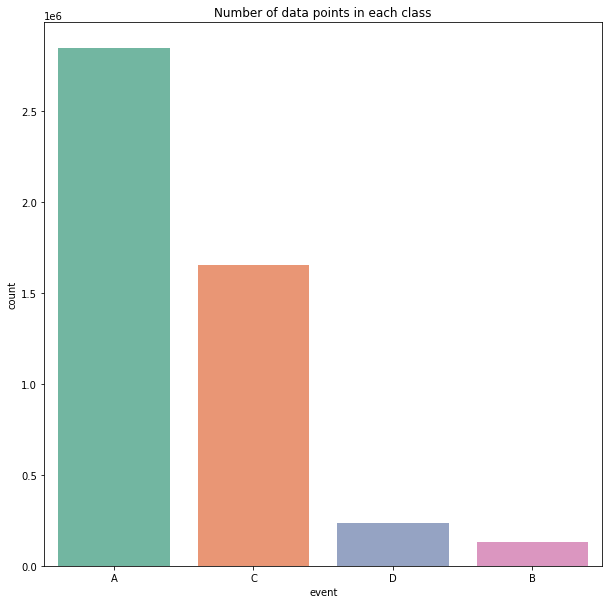

In [ ]:
print('The distribution of classes in the training data set')
print('-'*100)
print(aviation_df['event'].value_counts())
print('-'*100)

plt.figure(figsize=(10, 10))
sns.countplot(aviation_df['event'],palette='Set2')
plt.title('Number of data points in each class')

The event A has maximum number of classes in the dataset with 2848809 data points.

The event C is the second maximum number of classes in the dataset with 1652686 data points.

The event D is the next most frequently occurring class with 235329 data points.

The event B is the least occurring class with 130597 data points. 


# Check for Missing values

In [ ]:
aviation_df.isnull().sum()

crew          0
experiment    0
time          0
seat          0
eeg_fp1       0
eeg_f7        0
eeg_f8        0
eeg_t4        0
eeg_t6        0
eeg_t5        0
eeg_t3        0
eeg_fp2       0
eeg_o1        0
eeg_p3        0
eeg_pz        0
eeg_f3        0
eeg_fz        0
eeg_f4        0
eeg_c4        0
eeg_p4        0
eeg_poz       0
eeg_c3        0
eeg_cz        0
eeg_o2        0
ecg           0
r             0
gsr           0
event         0
dtype: int64

The training dataset has no missing values. 

##Univariate Analysis

The number of experiments in each class
----------------------------------------------------------------------------------------------------
DA    1658393
CA    1658376
SS    1550652
Name: experiment, dtype: int64
----------------------------------------------------------------------------------------------------
The number of experiments in each class(%) 
----------------------------------------------------------------------------------------------------
CA  34
DA  34
SS  31
----------------------------------------------------------------------------------------------------


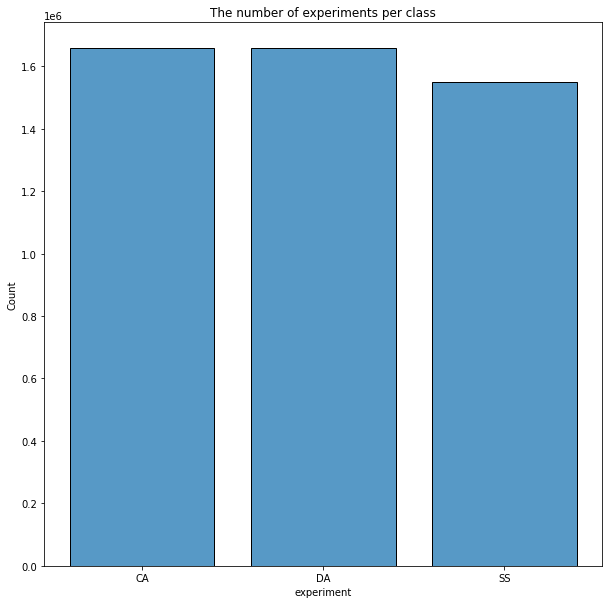

In [ ]:
plt.figure(figsize=(10, 10))
sns.histplot(data=aviation_df, x="experiment",shrink = 0.8)
plt.title('The number of experiments per class')

experiment_values = aviation_df['experiment'].value_counts()
print('The number of experiments in each class')
print('-'*100)
print(experiment_values)
print('-'*100)

total= np.sum(experiment_values)

print('The number of experiments in each class(%) ')
print('-'*100)
print('CA ',int((experiment_values['CA']/total)*100) )
print('DA ',int((experiment_values['DA']/total)*100) )
print('SS ',int((experiment_values['SS']/total)*100) )
print('-'*100)

The training set has 34% of experiments of CA and DA each. The remaining 31% of the experiments are for SS.

6     552958
4     552881
2     552868
5     552815
3     552795
7     552769
13    552724
8     549959
1     447652
Name: crew, dtype: int64


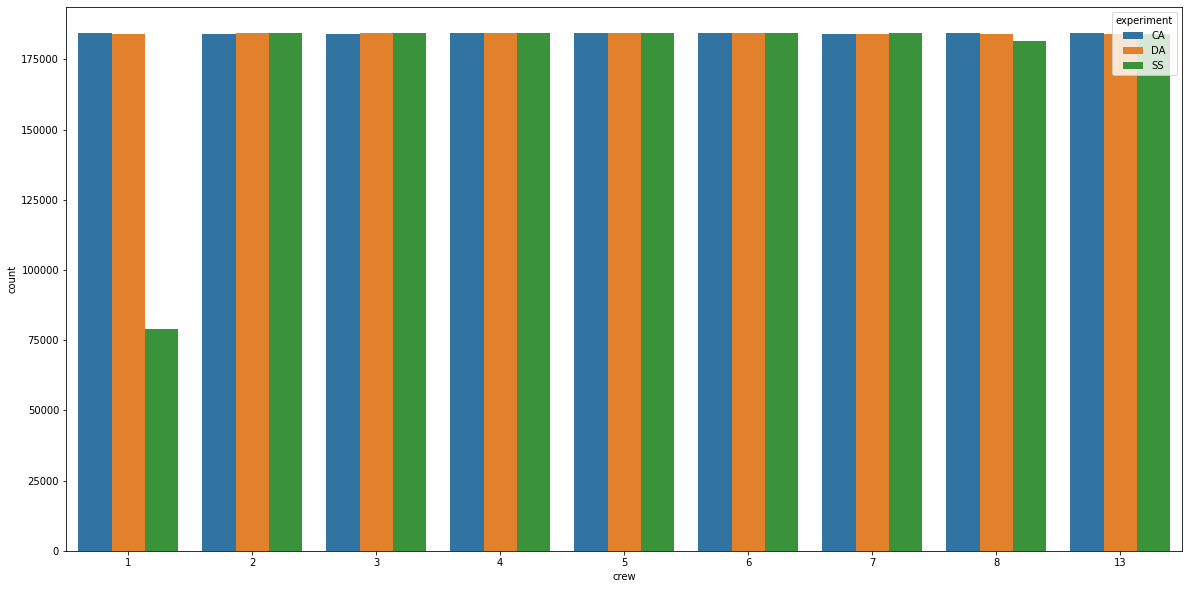

In [ ]:
print(aviation_df['crew'].value_counts(ascending=False))
plt.figure(figsize=(20, 10))
sns.countplot(data=aviation_df, x="crew",hue='experiment')


All the crews have an almost equal number of experiments conducted for the CA,DA classes. Crew 1 has only around 75000 of experiments conducted for SS class while all the other crews have around 180000 of experiments conducted for the same class. 

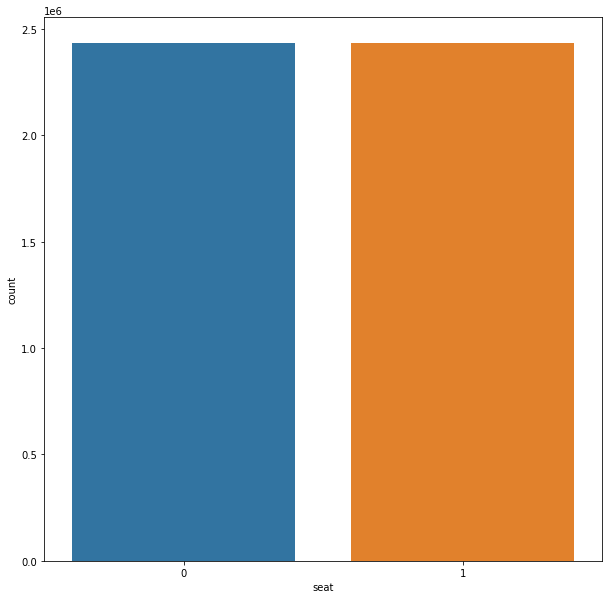

In [ ]:
plt.figure(figsize=(10, 10))
sns.countplot(data=aviation_df, x="seat")

Equal number of data for both seat 0 and seat 1

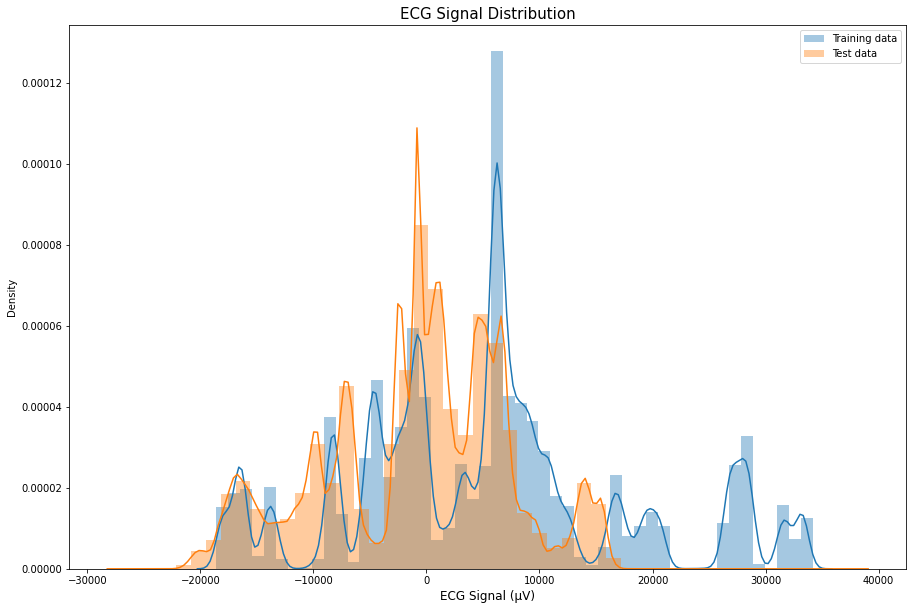

In [ ]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(15,10))
sns.distplot(aviation_df['ecg'], label='Training data')
sns.distplot(aviation_test_df['ecg'], label='Test data')
plt.xlabel("ECG Signal (µV)", fontsize=12)
plt.title("ECG Signal Distribution", fontsize=15)
plt.legend()
plt.show()

In the PDF, we observe that the ECG values are between -20000 to ~35000 mv.The ECG values in the test data are between -20000 to ~20000 mv only. We see very few values beond 30000 mv.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


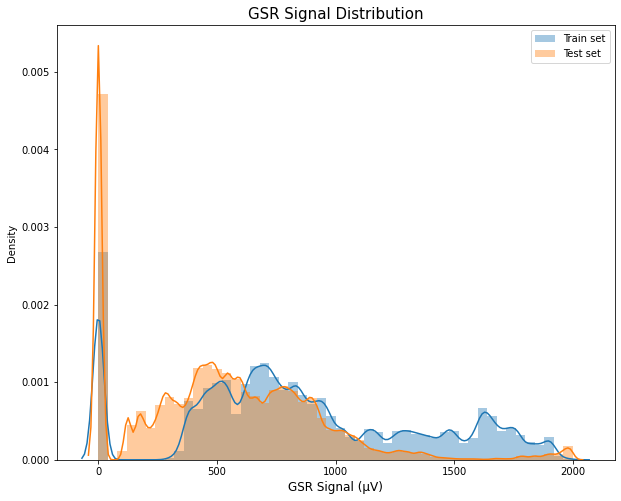

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(aviation_df['gsr'], label='Train set')
sns.distplot(aviation_test_df['gsr'], label='Test set')
plt.xlabel("GSR Signal (µV)", fontsize=12)
plt.title("GSR Signal Distribution", fontsize=15)
plt.legend()
plt.show()

The GSR has values between 0 to 2000.We see that a lot of data points have near zero values compared to the other values in the range and almost no data points in the range between 10 to ~200.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


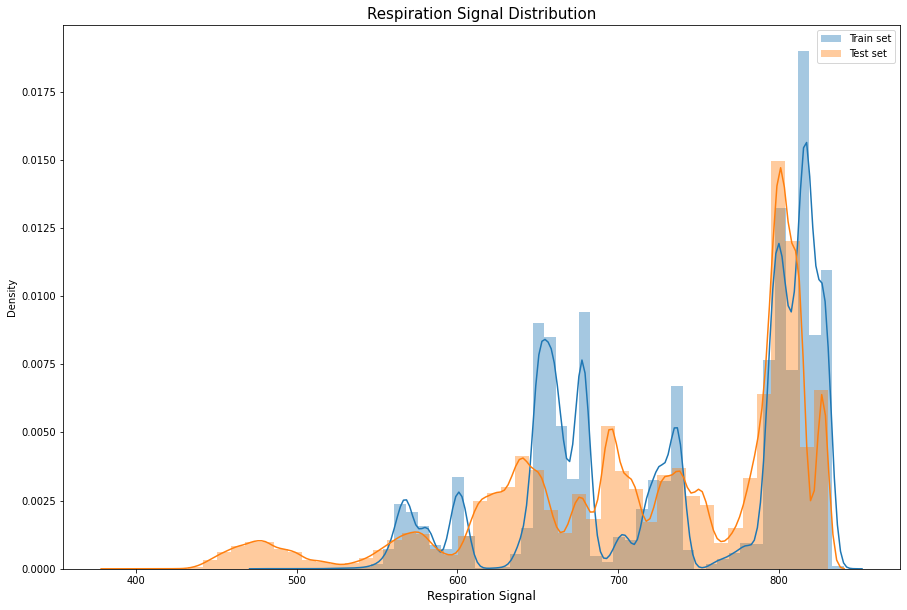

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(aviation_df['r'], label='Train set')
sns.distplot(aviation_test_df['r'], label='Test set')
plt.legend()
plt.xlabel("Respiration Signal", fontsize=12)
plt.title("Respiration Signal Distribution", fontsize=15)
plt.show()

The Respiration has values between 550 to 850 mv. There is a spike for values between ~820 - 830mv.

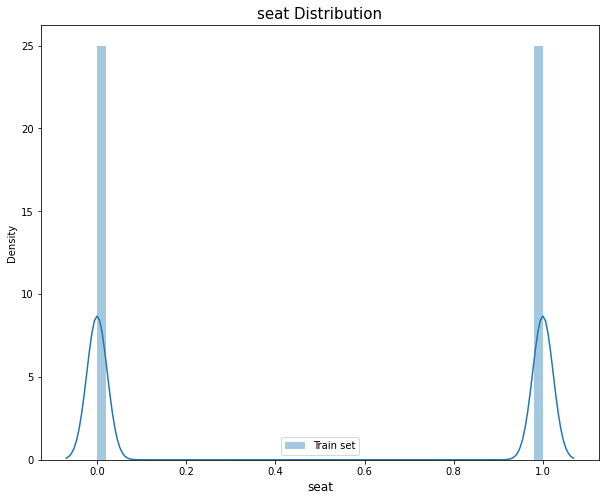

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(aviation_df['seat'], label='Train set')
sns.distplot(aviation_test_df['seat'], label='Test set')
plt.legend()
plt.xlabel("seat", fontsize=12)
plt.title("seat Distribution", fontsize=15)
plt.show()

The PDF for seat shows that the data is equally distributed for this feature.


# Bi-variate Analysis

In the following analysis, we note the events that occur in each experiment class and compare the duration of each event during the course of the experiment. 

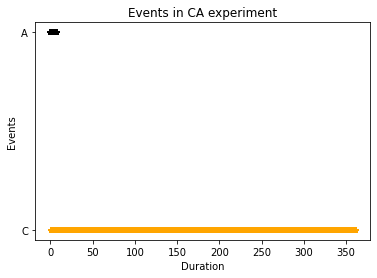

In [ ]:
subset1 = aviation_df.loc[(aviation_df['event'] == 'A') &(aviation_df['experiment'] == 'CA')]

subset1.sort_values(by='time')

subset2 = aviation_df.loc[(aviation_df['event'] == 'C') &(aviation_df['experiment'] == 'CA')]

subset2.sort_values(by='time')

plt.plot(subset2['time'],subset2['event'], color="orange", marker="*")
plt.plot(subset1['time'],subset1['event'], color="black", marker="*")
plt.title('Events in CA experiment')
plt.xlabel('Duration')
plt.ylabel('Events')
plt.show()

In the CA experiment, it is observed that the pilots are in the Baseline state (A) for around 10 seconds at the beginning of the experiment.After that the CA state is maintained for the rest of the experiment.
The crew does not revert back to the Baseline state.

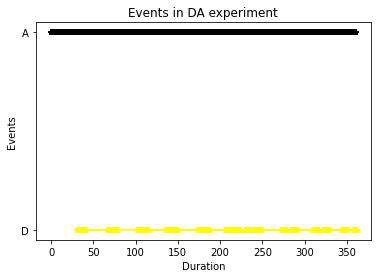

In [ ]:


subset1 = aviation_df.loc[(aviation_df['event'] == 'A') &(aviation_df['experiment'] == 'DA')]

subset1.sort_values(by='time')

subset2 = aviation_df.loc[(aviation_df['event'] == 'D') &(aviation_df['experiment'] == 'DA')]

subset2.sort_values(by='time')

plt.plot(subset2['time'],subset2['event'], color="yellow", marker="*")
plt.plot(subset1['time'],subset1['event'], color="black", marker="*")
plt.title('Events in DA experiment')
plt.xlabel('Duration')
plt.ylabel('Events')
plt.show()

In the DA experiment, it is observed that the crew oscillate between the Baseline state and the DA state throughout the duration of the experiment.

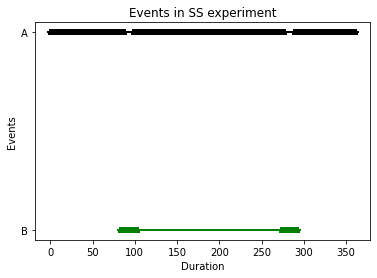

In [ ]:
subset1 = aviation_df.loc[(aviation_df['event'] == 'A') &(aviation_df['experiment'] == 'SS')]

subset1.sort_values(by='time')

subset2 = aviation_df.loc[(aviation_df['event'] == 'B') &(aviation_df['experiment'] == 'SS')]

subset2.sort_values(by='time')

plt.plot(subset2['time'],subset2['event'], color="green", marker="*")
plt.plot(subset1['time'],subset1['event'], color="black", marker="*")
plt.title('Events in SS experiment')
plt.xlabel('Duration')
plt.ylabel('Events')
plt.show()

In the SS experiment, it is observed that the SS state is achieved around 70s -290s in the duration of the experiment.

# Feature v/s Target

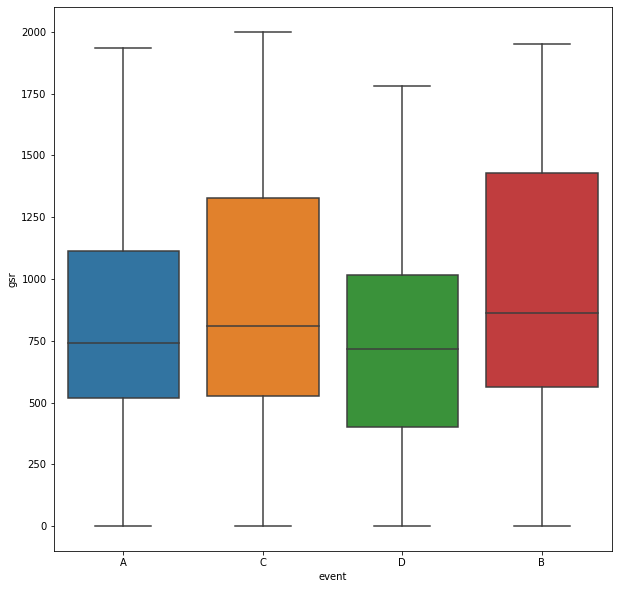

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(x=aviation_df['event'],y=aviation_df['gsr'])

1. The GSR feature shows some overlap amongst classes but still can be used to differentiate amongst the classes.

2. The minimum value is zero for all classes.

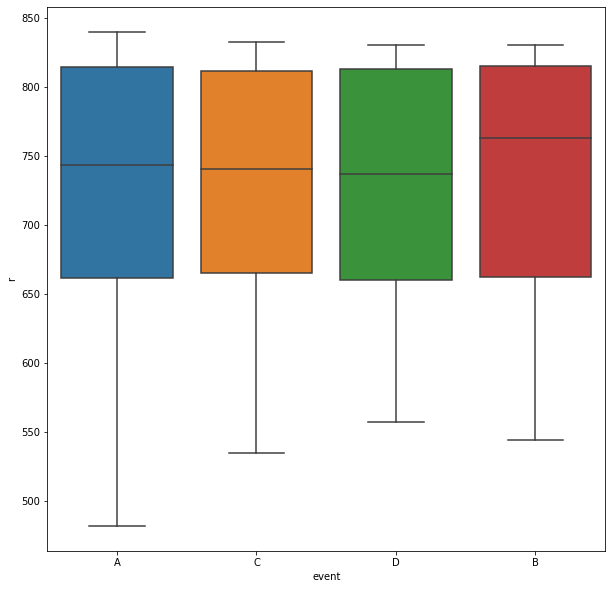

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(x=aviation_df['event'],y=aviation_df['r'])

1. The plot shows a lot of overlap between classes for the Respiration feature. It would be difficult to predict the event with just the Respiration feature.
2. The minimum value for Respiration varies per class.

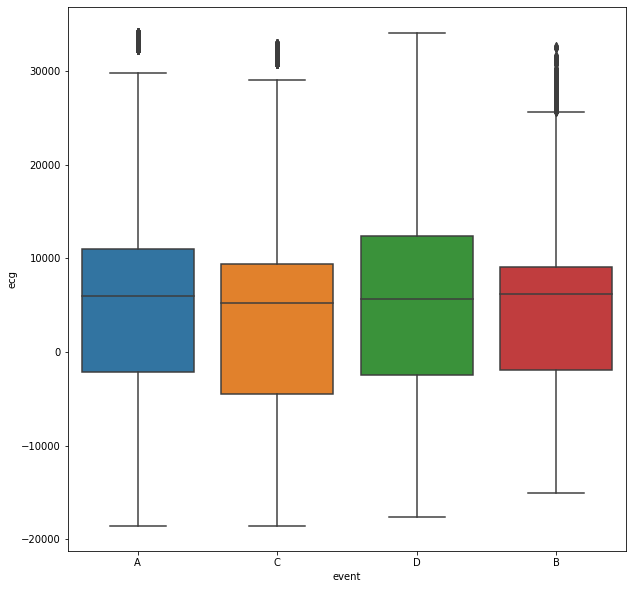

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(x=aviation_df['event'],y=aviation_df['ecg'])

1. There are some outliers found for ECG feature in the classes - A,C,B

2. Since, the objective is to look for physiological factors that can predict the cognitive state of the crew, these outliers might be useful in the prediction of the respective class. Hence, the outliers should not be removed.

3. There are more number of outliers for class B (Startle/Surprise)
4. When the ECG values are more than 10000 mv, the pilot is more likely to be in the D state and when the values are in the negative, the pilot is more likely to be in the C state.


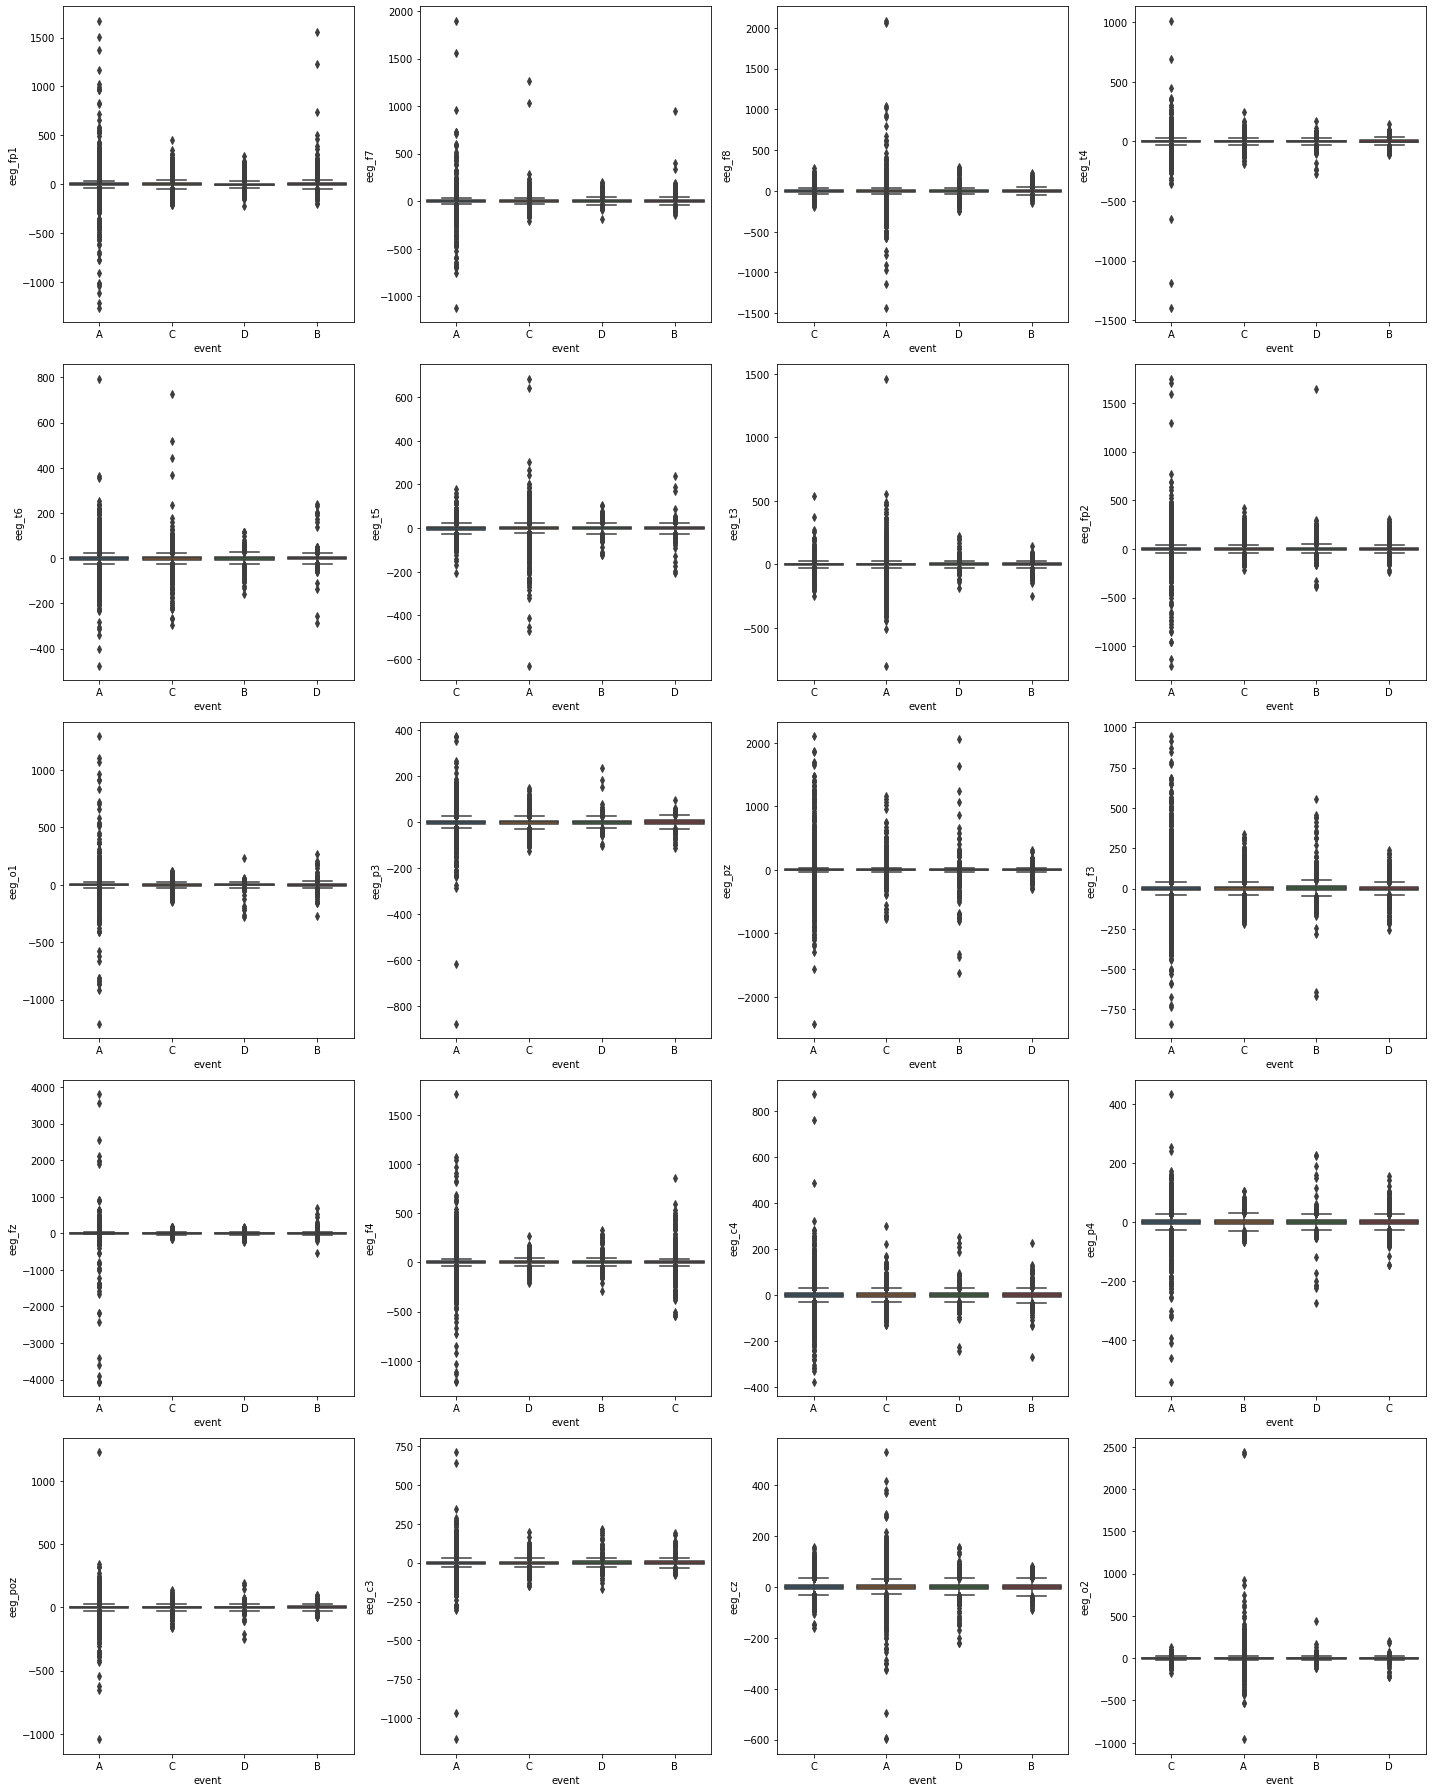

In [ ]:
eeg_feature_names = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", 
                "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", 
                "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", 
                "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]

plt.figure(figsize=(20,25))
i = 0

for ef in eeg_feature_names:
    i += 1
    plt.subplot(5, 4, i)
    sns.boxplot(x='event', y=ef, data=aviation_df.sample(50000))
    plt.tight_layout()    

plt.show()                

#Correlation between the features

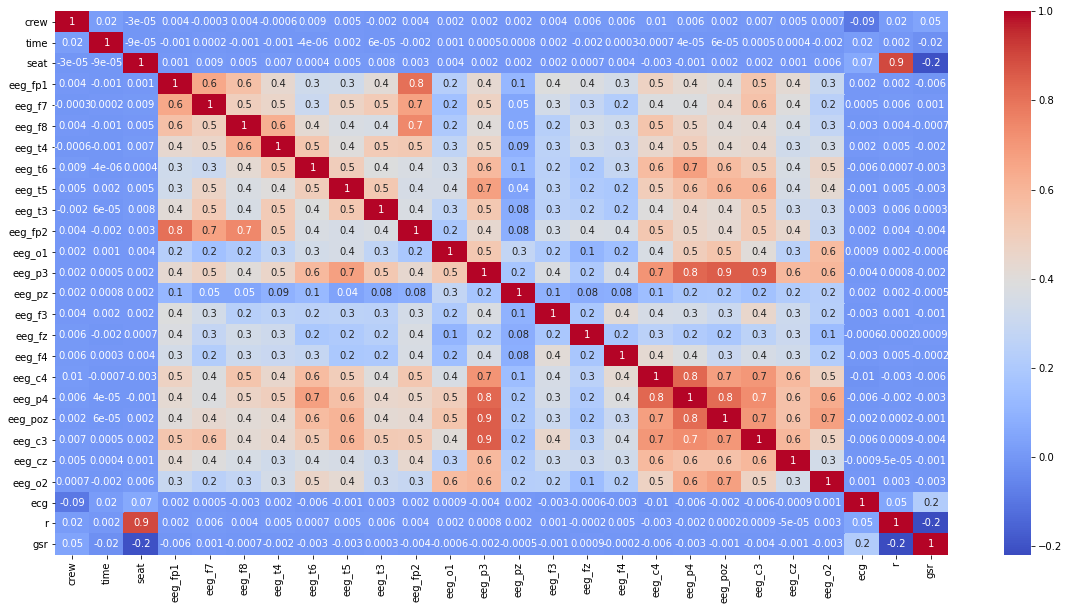

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(aviation_df.corr(),annot=True,fmt='.1g',cmap= 'coolwarm')

The correlation matrix makes the following observations:
1. Most of the EEG readings are strongly correlated to each other. 
2. ECG and GSR are weakly correlated with a correlation of just 0.2
3. GSR and seat are also weakly correlated.
4. Though seat and r are strongly correlated , it is unlikely that the pilot's respiration depends on whether he is seated right or left.

Further analysis of the above found correlation

ECG v/s GSR

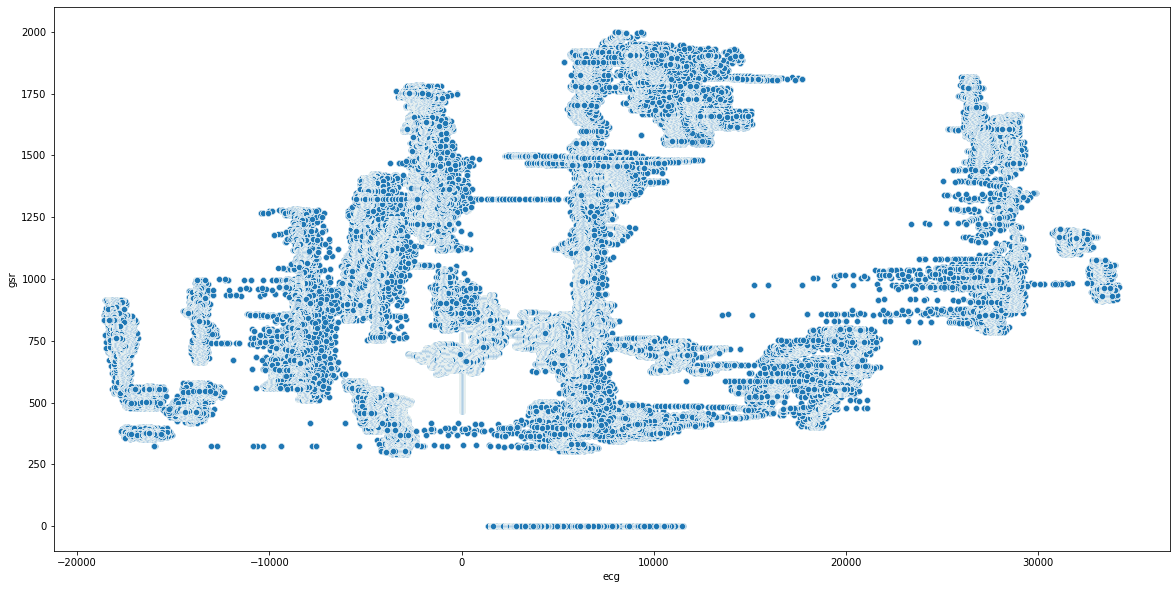

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=aviation_df['ecg'],y=aviation_df['gsr'])

The heat map indicated that the ECG and GSR are weakly correlated. This scatter plot between the two fails to show a clear correlation between the two features. Hence, any correlation between these two features are irrelevant. 

Seat V/s GSR

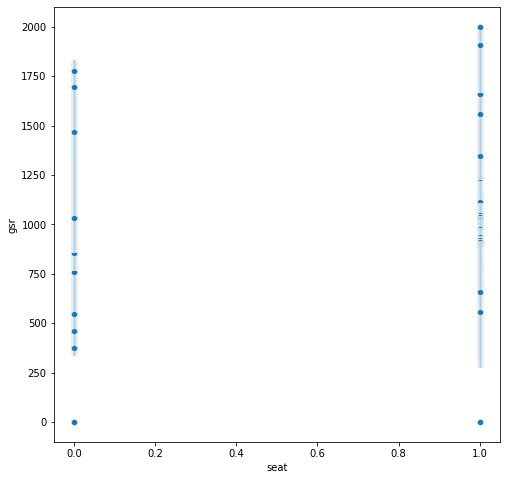

In [ ]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=aviation_df['seat'],y=aviation_df['gsr'])

From the scatter plot, it is clear that there is no correlation between the seat and gsr. Higher values recorded for seat 1 may have been misconstrued as correlation. However, it may be logical to say that being seated on the left or right may have no impact on the GSR.

Seat v/s Respiration

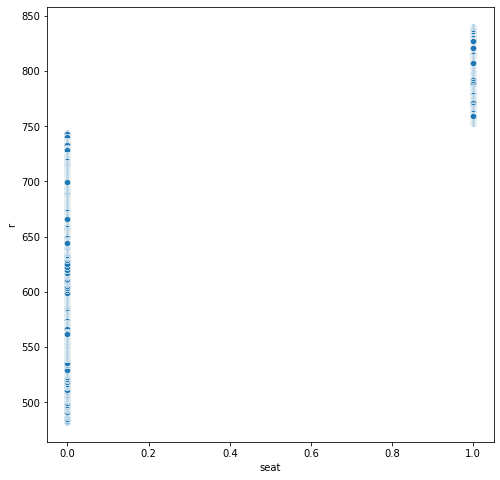

In [ ]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=aviation_df['seat'],y=aviation_df['r'])

From the scatterplot, we can spot that the seat 1 has higher readings of 'r' than the seat 0. However, it may be logical to say that being seated on the left or right may have no impact on the Respiration of the pilot.

The only correlation that seems valid is between the EEG parameters. EEG parameters will collectively be used to derive features.

## Data Cleaning

#Removing Noise

The physiological features have been captured from electronic sensory devices. These devices pick on a lot of external noise along with the sensory data. 

Here, we will separate out the actual data from the noise.


In [ ]:
aviation_df.columns

Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr', 'event'],
      dtype='object')

In [ ]:
# The data of one crew i.e crew 5 is picked to analyse and evaluate noise in the data.

#Create separate subsets of crew 5 for each experiment class
crew_5_df_ss = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'SS')]
crew_5_df_ca = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'CA')]
crew_5_df_da = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'DA')]

#Sort the data by time so that the data is sequential
crew_5_df_ss.sort_values(by='time')
crew_5_df_ca.sort_values(by='time')
crew_5_df_da.sort_values(by='time')

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
2290448,5,DA,0.035156,0,-28.054001,-28.909599,-28.183201,-14.147300,-23.223400,-6.102350,-41.167801,-21.22290,-27.74110,-39.170601,-27.969200,-26.29780,-30.676500,-42.433498,-49.408199,-44.695099,-36.494598,-38.009499,-38.41000,-33.602699,-2740.580078,647.924988,1599.459961,A
2290449,5,DA,0.039062,0,-17.202200,-15.306000,-44.697399,-32.931999,-34.666401,6.471460,-5.935390,-18.34650,-12.55880,-19.108700,-14.955900,-12.51720,-12.470200,-11.387600,-1.764620,-11.839000,-16.068399,-24.049101,-18.80460,-13.587000,-2740.580078,647.924988,1599.459961,A
2290450,5,DA,0.042969,0,-4.906310,-3.739110,-3.345420,14.688700,-26.457701,-0.205576,11.477200,-11.04950,-6.02811,-7.846340,-4.428600,-1.44338,-2.400170,0.533921,-12.035700,-7.898720,-8.224800,-12.040500,-11.70780,-4.400690,-2740.580078,647.924988,1599.459961,A
2290451,5,DA,0.046875,0,7.045360,8.471630,2.217020,28.524500,0.296500,-0.617746,6.515300,7.95148,4.98013,2.910230,3.627240,9.63815,13.580300,36.284901,20.129900,10.576200,3.685950,1.621330,5.17495,6.437550,-2740.580078,647.924988,1599.459961,A
2290452,5,DA,0.050781,0,4.820220,6.314090,-26.190100,16.920000,5.581530,4.250710,-2.408710,6.54667,-2.15983,0.133591,6.150770,8.09426,5.315470,3.925070,-4.190660,11.542200,-0.939785,0.394200,-1.82683,3.203650,-2740.580078,647.924988,1599.459961,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2439407,5,DA,360.023438,0,-9.880410,-3.503890,-23.696899,1.210280,1.495490,-0.753854,-6.178800,-7.16440,-15.27100,-6.616410,1.294830,-3.28063,-3.481920,23.283800,-18.513500,-4.938940,-5.463900,-10.054900,-8.24135,-9.475190,-2731.790039,646.127014,1752.550049,A
2439408,5,DA,360.027344,0,-5.009290,0.462042,-21.882500,-50.407501,-8.766810,-6.966010,-5.147930,-1.01838,-15.39930,-2.871320,0.381980,3.68947,-0.637105,2.664300,-2.923630,1.337060,-1.721980,-4.344700,-3.68524,-3.812400,-2731.790039,646.127014,1752.550049,A
2439409,5,DA,360.031250,0,13.047300,16.393700,29.492599,18.029200,8.307730,14.874500,16.186001,18.44520,1.62274,14.999400,11.789700,20.18400,14.587500,3.972710,25.511801,25.538500,18.227100,13.480600,14.24610,15.843700,-2730.939941,646.122986,1752.560059,A
2439410,5,DA,360.035156,0,15.218600,20.400299,17.824699,32.913200,19.995199,12.988400,28.408001,18.34300,9.41592,20.077200,24.227400,17.31090,12.589400,9.826790,-0.539176,12.410000,17.787800,15.218600,13.66360,15.815000,-2730.939941,646.122986,1752.560059,A


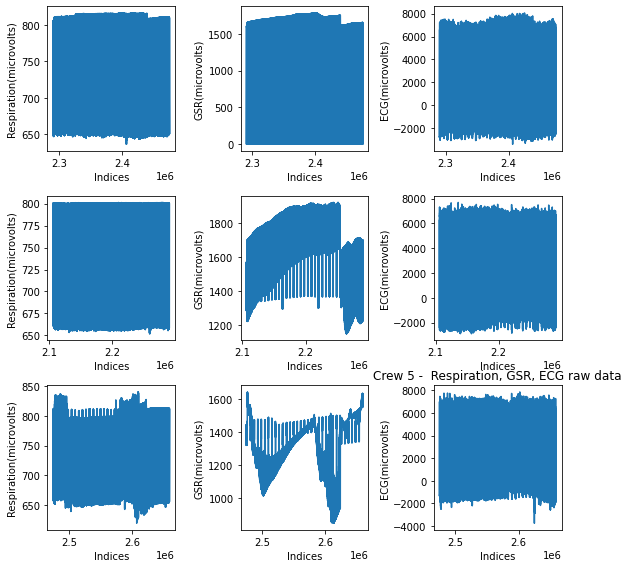

In [ ]:
#Plot crew 5 data - Respiration, GSR, ECG for each experiment class 

plt.figure(figsize=(8,8))

#Experiment class DA
plt.subplot(3,3, 1)
plt.plot(crew_5_df_da['r'])
plt.ylabel('Respiration(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 

plt.subplot(3,3, 2)
plt.plot(crew_5_df_da['gsr'])
plt.ylabel('GSR(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 

plt.subplot(3,3, 3)
plt.plot(crew_5_df_da['ecg'])
plt.ylabel('ECG(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 

#Experiment class CA
plt.subplot(3,3, 4)
plt.plot(crew_5_df_ca['r'])
plt.ylabel('Respiration(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 
plt.subplot(3,3, 5)
plt.plot(crew_5_df_ca['gsr'])
plt.ylabel('GSR(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 
plt.subplot(3,3, 6)
plt.plot(crew_5_df_ca['ecg'])
plt.ylabel('ECG(microvolts)')
plt.xlabel('Indices')
plt.tight_layout()

##Experiment class SS
plt.subplot(3,3, 7)
plt.plot(crew_5_df_ss['r'])
plt.ylabel('Respiration(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 
plt.subplot(3,3, 8)
plt.plot(crew_5_df_ss['gsr'])
plt.ylabel('GSR(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 
plt.subplot(3,3, 9)
plt.plot(crew_5_df_ss['ecg'])
plt.ylabel('ECG(microvolts)')
plt.xlabel('Indices')
plt.tight_layout()

plt.title('Crew 5 -  Respiration, GSR, ECG raw data')

plt.show()  

A subset of data was taken to observe the raw data for Respiration, GSR and ECG. These data were taken from crew 5.

It can be seen that the plot is indecipherable because of the noise present in the actual data for all the three features - Respiration, GSR, ECG. 

Respiration data are typically sinusoidal.But here, the sinusoidal pattern is not visible due to the noise.

Hence, we will have to remove the noise to be able to work with the data.


In [ ]:
#https://www.kaggle.com/stuartbman/introduction-to-physiological-data

#This function removes the noise from the raw data using the Butterworth filter
def denoise(frequency,raw_data,filter_order):

  #Use the Butterworth filter to filter noise. This filter filters out the noise. Noise is the data which is beyond the typical frequency of the sensory data.
  b, a = signal.butter(filter_order,frequency)

  y = signal.filtfilt(b, a, raw_data, padlen=150)

  return y

Text(0.5, 1.0, 'Crew 5 -  Denoised Respiration data')

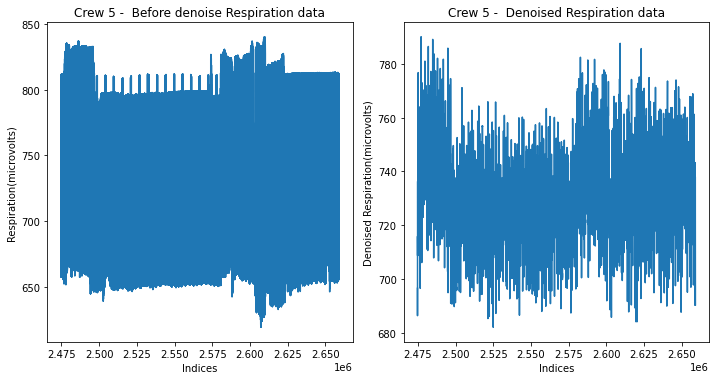

In [ ]:
#Denoise the Respiration data

denoised_r = denoise(0.05,aviation_df["r"],5) 
aviation_df['denoised_r'] = denoised_r


crew_5_df_ss = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'SS')]
crew_5_df_ss.sort_values(by='time')

plt.figure(figsize=(15,15))


plt.subplot(3,3, 1)
plt.plot(crew_5_df_ss['r'])
plt.ylabel('Respiration(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 
plt.title('Crew 5 -  Before denoise Respiration data')

plt.subplot(3,3, 2)
plt.plot(crew_5_df_ss['denoised_r'])
plt.ylabel('Denoised Respiration(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 

plt.title('Crew 5 -  Denoised Respiration data')

Text(0.5, 1.0, 'Crew 5 -  Denoised ECG')

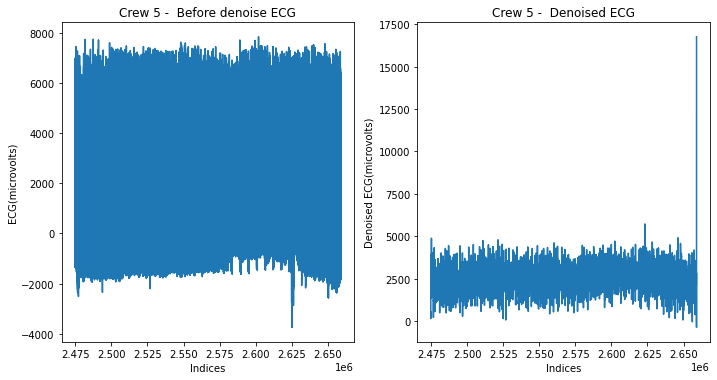

In [ ]:
#Denoise the ECG data

denoised_ecg = denoise(0.05,aviation_df["ecg"],5) 
aviation_df['denoised_ecg'] = denoised_ecg


crew_5_df_ss = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'SS')]
crew_5_df_ss.sort_values(by='time')

plt.figure(figsize=(15,15))

plt.subplot(3,3, 1)
plt.plot(crew_5_df_ss['ecg'])
plt.ylabel('ECG(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 
plt.title('Crew 5 -  Before denoise ECG')

plt.subplot(3,3, 2)
plt.plot(crew_5_df_ss['denoised_ecg'])
plt.ylabel('Denoised ECG(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 

plt.title('Crew 5 -  Denoised ECG')


In [ ]:

#Comparison of the de-noised Respiration and raw data.
denoised_r_df = pd.DataFrame()
denoised_r_df['raw_r'] = aviation_df['r']
denoised_r_df['denoised_r'] = denoised_r

denoised_r_df.tail()

,raw_r,denoised_r
4867416,758.981018,742.454262
4867417,666.289978,746.445797
4867418,758.981018,750.556834
4867419,666.289978,754.748935
4867420,758.981018,758.981990


In [ ]:
##Comparison of the de-noised ECG and raw data.
denoised_e_df = pd.DataFrame()
denoised_e_df['raw_ecg'] = aviation_df['ecg']
denoised_e_df['denoised_ecg'] = denoised_ecg

denoised_e_df.tail()

,raw_ecg,denoised_ecg
4867416,-8395.570313,-9346.830972
4867417,-13660.400391,-9117.029663
4867418,-8395.570313,-8880.389302
4867419,-13660.400391,-8639.112173
4867420,-8395.570313,-8395.493706


In [ ]:
#Create the subset of crew 5 again to visualise the denoised data

crew_5_df_ss = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'SS')][1000:3000]
crew_5_df_ca = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'CA')][1000:3000]
crew_5_df_da = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'DA')][1000:3000]

crew_5_df_ss.sort_values(by='time')
crew_5_df_ca.sort_values(by='time')
crew_5_df_da.sort_values(by='time')



,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event,denoised_r,denoised_ecg
2291448,5,DA,10.039062,0,226.580994,160.901993,100.850998,45.921001,44.768200,-9.645180,51.495399,223.576004,36.226398,65.126099,34.335899,126.776001,150.147003,174.667007,102.068001,61.397202,52.148399,98.768700,91.280403,50.875599,-2828.320068,648.653992,1604.930054,A,727.956759,1795.771986
2291449,5,DA,10.039062,1,211.052994,108.436996,88.111099,30.307501,20.680401,18.665600,39.806999,171.839996,21.180799,30.566500,32.076199,129.237000,115.188004,100.742996,44.186901,26.306700,23.044600,61.950500,54.675201,15.005900,6416.279785,807.054993,0.000000,A,727.953531,1795.099638
2291450,5,DA,10.042969,0,221.682007,153.447006,97.243500,15.398400,42.882599,0.746349,54.637402,215.692001,38.427898,62.922798,27.297701,118.169998,129.688004,120.176003,62.999901,50.022598,38.059502,90.168404,71.836800,35.572701,-2828.320068,648.653992,1604.930054,A,727.948028,1794.327254
2291451,5,DA,10.042969,1,201.475006,102.411003,81.756104,30.053400,22.428699,21.128300,37.680099,163.432007,19.960899,27.997900,30.820499,122.555000,108.744003,88.733398,38.088600,24.366400,20.347601,56.653702,51.915199,15.068600,6416.279785,807.054993,0.000000,A,727.940665,1793.473383
2291452,5,DA,10.046875,0,253.509003,174.207993,124.218002,37.356701,12.337100,-13.991700,49.322800,243.828995,39.274502,57.254601,23.202000,148.283997,148.352997,135.242004,62.372700,56.260700,42.568901,112.574997,84.158096,32.508801,-2828.320068,648.653992,1604.930054,A,727.931846,1792.556448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293443,5,DA,102.933594,1,3.086190,3.350180,0.059036,3.446720,4.251270,1.940290,2.450160,3.445330,4.682850,-0.498848,7.000120,2.000330,-0.522262,6.113890,-1.943150,1.532040,4.011040,2.667150,7.227610,2.032860,6408.720215,810.489014,0.000000,A,730.259096,2006.952181
2293444,5,DA,102.937500,0,8.459570,3.955980,22.893400,12.719300,5.703450,-9.579610,1.302250,5.712360,-5.001250,-7.622250,0.803156,6.623080,6.020340,5.674490,-3.664220,-6.309030,-8.000750,0.237607,3.059860,-5.883420,-2368.479980,650.046021,1657.930054,A,730.260770,2004.158322
2293445,5,DA,102.937500,1,2.634490,4.945620,3.186420,0.293181,1.399270,6.930720,6.498250,0.568095,4.740810,2.281260,6.021640,-1.505640,-1.666340,3.556280,-6.137600,0.161547,3.948910,0.960795,6.091390,2.285490,6408.720215,810.489014,0.000000,A,730.262368,2002.007086
2293446,5,DA,102.941406,0,4.815800,-1.607640,11.681300,-2.970360,5.740400,-9.415130,-0.344204,0.353467,-9.210260,-10.410400,-4.776750,1.697240,1.547130,-6.835180,-17.015499,-2.155230,-9.685550,-1.343200,-1.177480,-7.592680,-2368.479980,650.046021,1657.930054,A,730.263899,2000.440455


Crew 5 -  Respiration, GSR, ECG raw data


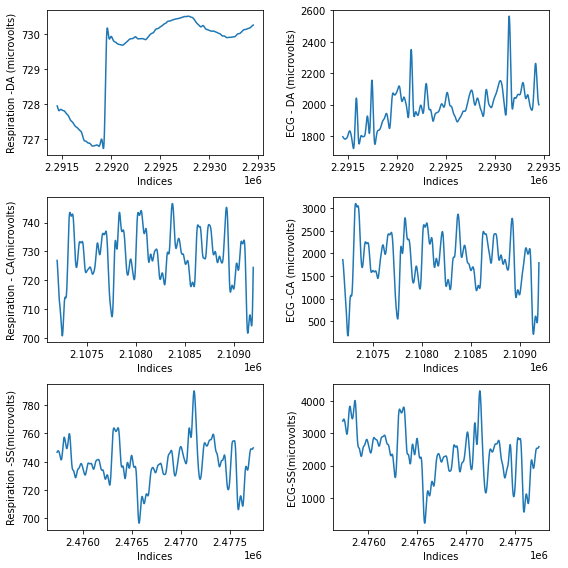

In [ ]:

print('Crew 5 -  Respiration, GSR, ECG raw data')
plt.figure(figsize=(8,8))


plt.subplot(3,2, 1)
plt.plot(crew_5_df_da['denoised_r'])
plt.ylabel('Respiration -DA (microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 

plt.subplot(3,2, 2)
plt.plot(crew_5_df_da['denoised_ecg'])
plt.ylabel('ECG - DA (microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 

plt.subplot(3,2, 3)
plt.plot(crew_5_df_ca['denoised_r'])
plt.ylabel('Respiration - CA(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 
plt.subplot(3,2, 4)
plt.plot(crew_5_df_ca['denoised_ecg'])
plt.ylabel('ECG -CA (microvolts)')
plt.xlabel('Indices')
plt.tight_layout()

plt.subplot(3,2, 5)
plt.plot(crew_5_df_ss['denoised_r'])
plt.ylabel('Respiration -SS(microvolts)')
plt.xlabel('Indices')
plt.tight_layout() 
plt.subplot(3,2, 6)
plt.plot(crew_5_df_ss['denoised_ecg'])
plt.ylabel('ECG-SS(microvolts)')
plt.xlabel('Indices')
plt.tight_layout()
plt.show()  

We see a drastic difference in the denoised data and are able to actually follow the pattern in data.

##Feature Engineering

Derive Respiration Rate

In [ ]:
#Extract the respiration rate signal data using a sampling frequency of 256

resp_rate_op = resp.resp(aviation_df['denoised_r'],sampling_rate=256, show=False)

print(resp_rate_op['resp_rate_ts'].shape)
print(resp_rate_op['resp_rate'].shape)

(3789,)
(3789,)


In [ ]:
#This function applies linear interpolation to match the timestamps of the experiments
def interpolation_fn(timestamps,biosppy_timestamps, biosppy_values):

    interpolation = interp1d(biosppy_timestamps,biosppy_values, kind="linear", fill_value="extrapolate") 
    return interpolation(timestamps)

In [ ]:
resp_rate_arr = interpolation_fn(aviation_df["time"],resp_rate_op['resp_rate_ts'],resp_rate_op['resp_rate'])

print(resp_rate_arr.shape)

(4867421,)


In [ ]:
aviation_df['r_rate'] =resp_rate_arr

crew_5_df_ss = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'SS')][1000:3000]
crew_5_df_ca = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'CA')][1000:3000]
crew_5_df_da = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'DA')][1000:3000]

crew_5_df_ss.sort_values(by='time')
crew_5_df_ca.sort_values(by='time')
crew_5_df_da.sort_values(by='time')

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event,denoised_r,denoised_ecg,r_rate
2291448,5,DA,10.039062,0,226.580994,160.901993,100.850998,45.921001,44.768200,-9.645180,51.495399,223.576004,36.226398,65.126099,34.335899,126.776001,150.147003,174.667007,102.068001,61.397202,52.148399,98.768700,91.280403,50.875599,-2828.320068,648.653992,1604.930054,A,727.956759,1795.771986,0.125513
2291449,5,DA,10.039062,1,211.052994,108.436996,88.111099,30.307501,20.680401,18.665600,39.806999,171.839996,21.180799,30.566500,32.076199,129.237000,115.188004,100.742996,44.186901,26.306700,23.044600,61.950500,54.675201,15.005900,6416.279785,807.054993,0.000000,A,727.953531,1795.099638,0.125513
2291450,5,DA,10.042969,0,221.682007,153.447006,97.243500,15.398400,42.882599,0.746349,54.637402,215.692001,38.427898,62.922798,27.297701,118.169998,129.688004,120.176003,62.999901,50.022598,38.059502,90.168404,71.836800,35.572701,-2828.320068,648.653992,1604.930054,A,727.948028,1794.327254,0.125520
2291451,5,DA,10.042969,1,201.475006,102.411003,81.756104,30.053400,22.428699,21.128300,37.680099,163.432007,19.960899,27.997900,30.820499,122.555000,108.744003,88.733398,38.088600,24.366400,20.347601,56.653702,51.915199,15.068600,6416.279785,807.054993,0.000000,A,727.940665,1793.473383,0.125520
2291452,5,DA,10.046875,0,253.509003,174.207993,124.218002,37.356701,12.337100,-13.991700,49.322800,243.828995,39.274502,57.254601,23.202000,148.283997,148.352997,135.242004,62.372700,56.260700,42.568901,112.574997,84.158096,32.508801,-2828.320068,648.653992,1604.930054,A,727.931846,1792.556448,0.125528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293443,5,DA,102.933594,1,3.086190,3.350180,0.059036,3.446720,4.251270,1.940290,2.450160,3.445330,4.682850,-0.498848,7.000120,2.000330,-0.522262,6.113890,-1.943150,1.532040,4.011040,2.667150,7.227610,2.032860,6408.720215,810.489014,0.000000,A,730.259096,2006.952181,0.201990
2293444,5,DA,102.937500,0,8.459570,3.955980,22.893400,12.719300,5.703450,-9.579610,1.302250,5.712360,-5.001250,-7.622250,0.803156,6.623080,6.020340,5.674490,-3.664220,-6.309030,-8.000750,0.237607,3.059860,-5.883420,-2368.479980,650.046021,1657.930054,A,730.260770,2004.158322,0.201983
2293445,5,DA,102.937500,1,2.634490,4.945620,3.186420,0.293181,1.399270,6.930720,6.498250,0.568095,4.740810,2.281260,6.021640,-1.505640,-1.666340,3.556280,-6.137600,0.161547,3.948910,0.960795,6.091390,2.285490,6408.720215,810.489014,0.000000,A,730.262368,2002.007086,0.201983
2293446,5,DA,102.941406,0,4.815800,-1.607640,11.681300,-2.970360,5.740400,-9.415130,-0.344204,0.353467,-9.210260,-10.410400,-4.776750,1.697240,1.547130,-6.835180,-17.015499,-2.155230,-9.685550,-1.343200,-1.177480,-7.592680,-2368.479980,650.046021,1657.930054,A,730.263899,2000.440455,0.201976


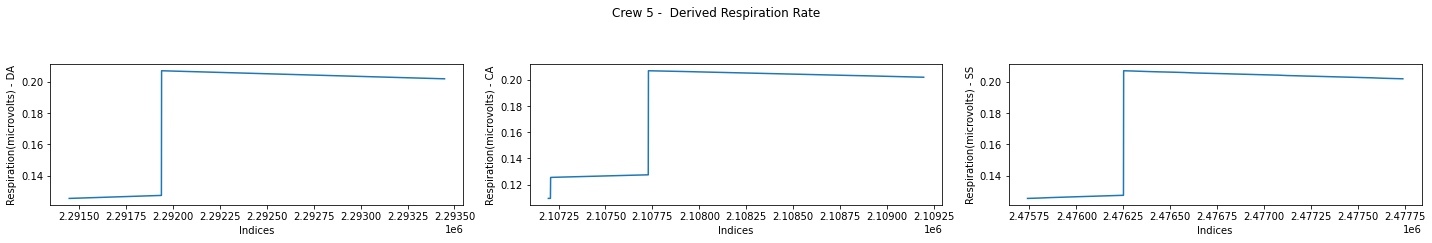

In [ ]:
fig = plt.figure(figsize=(20,8))
fig.suptitle('Crew 5 -  Derived Respiration Rate')

plt.subplot(3,3, 1)
plt.plot(crew_5_df_da['r_rate'])
plt.ylabel('Respiration(microvolts) - DA')
plt.xlabel('Indices')
plt.tight_layout() 

plt.subplot(3,3, 2)
plt.plot(crew_5_df_ca['r_rate'])
plt.ylabel('Respiration(microvolts) - CA')
plt.xlabel('Indices')
plt.tight_layout() 

plt.subplot(3,3, 3)
plt.plot(crew_5_df_ss['r_rate'])
plt.ylabel('Respiration(microvolts) - SS')
plt.xlabel('Indices')
plt.tight_layout() 

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()  

Deriving Heart Rate 

In [ ]:
heart_rate_op = ecg.ecg(signal=aviation_df['denoised_ecg'], sampling_rate=256, show=False)

print(heart_rate_op['heart_rate'].shape)


(1960,)


In [ ]:
heart_rate_arr = interpolation_fn(aviation_df["time"],heart_rate_op['heart_rate_ts'],heart_rate_op['heart_rate'])

print(heart_rate_arr.shape)

(4867421,)


In [ ]:
aviation_df['heart_rate'] =heart_rate_arr

crew_5_df_ss = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'SS')][1000:10000]
crew_5_df_ca = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'CA')][1000:10000]
crew_5_df_da = aviation_df.loc[(aviation_df['crew'] == 5) & (aviation_df['experiment'] == 'DA')][1000:10000]

crew_5_df_ss.sort_values(by='time')
crew_5_df_ca.sort_values(by='time')
crew_5_df_da.sort_values(by='time')

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event,denoised_r,denoised_ecg,r_rate,heart_rate
2291448,5,DA,10.039062,0,226.580994,160.901993,100.850998,45.921001,44.768200,-9.645180,51.495399,223.576004,36.226398,65.126099,34.335899,126.776001,150.147003,174.667007,102.068001,61.397202,52.148399,98.768700,91.280403,50.875599,-2828.320068,648.653992,1604.930054,A,727.956759,1795.771986,0.125513,112.773244
2291449,5,DA,10.039062,1,211.052994,108.436996,88.111099,30.307501,20.680401,18.665600,39.806999,171.839996,21.180799,30.566500,32.076199,129.237000,115.188004,100.742996,44.186901,26.306700,23.044600,61.950500,54.675201,15.005900,6416.279785,807.054993,0.000000,A,727.953531,1795.099638,0.125513,112.773244
2291450,5,DA,10.042969,0,221.682007,153.447006,97.243500,15.398400,42.882599,0.746349,54.637402,215.692001,38.427898,62.922798,27.297701,118.169998,129.688004,120.176003,62.999901,50.022598,38.059502,90.168404,71.836800,35.572701,-2828.320068,648.653992,1604.930054,A,727.948028,1794.327254,0.125520,112.772130
2291451,5,DA,10.042969,1,201.475006,102.411003,81.756104,30.053400,22.428699,21.128300,37.680099,163.432007,19.960899,27.997900,30.820499,122.555000,108.744003,88.733398,38.088600,24.366400,20.347601,56.653702,51.915199,15.068600,6416.279785,807.054993,0.000000,A,727.940665,1793.473383,0.125520,112.772130
2291452,5,DA,10.046875,0,253.509003,174.207993,124.218002,37.356701,12.337100,-13.991700,49.322800,243.828995,39.274502,57.254601,23.202000,148.283997,148.352997,135.242004,62.372700,56.260700,42.568901,112.574997,84.158096,32.508801,-2828.320068,648.653992,1604.930054,A,727.931846,1792.556448,0.125528,112.771017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300443,5,DA,115.605469,1,-0.921922,-3.426250,-9.101540,-3.472510,-4.567150,-8.435210,-5.419160,-7.118280,-13.109100,-11.463300,-4.115080,-8.482430,-2.436820,4.598940,-4.996300,-6.330720,-10.954700,-7.359880,0.237480,-9.037460,6404.250000,810.895996,0.000000,A,730.023339,2318.566242,0.175689,94.564056
2300444,5,DA,115.609375,0,21.908800,10.040600,18.052401,-9.717810,-14.427000,2.697580,2.855810,15.112700,14.354600,9.626830,14.304400,3.580150,9.108100,4.476120,5.980740,8.351940,11.266100,10.955400,9.989480,13.627800,-1785.810059,649.124023,1672.709961,A,730.024959,2318.905014,0.175687,94.562546
2300445,5,DA,115.609375,1,1.372340,1.182560,-0.586110,2.638000,5.827170,2.422010,2.502780,0.204337,-3.261190,-0.820855,5.566750,-3.400270,0.235899,1.125500,-1.395520,0.037094,-2.588430,-1.409300,4.492280,-3.113090,6467.870117,810.953979,0.000000,A,730.026672,2319.196485,0.175687,94.562546
2300446,5,DA,115.613281,0,26.127100,15.944000,6.732360,10.348600,1.884730,-1.603440,5.928460,22.119900,19.033300,13.264400,11.974500,9.729460,11.463700,3.988600,-1.481670,-1.779020,13.795100,15.327500,9.333580,16.834900,-1785.810059,649.124023,1672.709961,A,730.028470,2319.432628,0.175684,94.561036


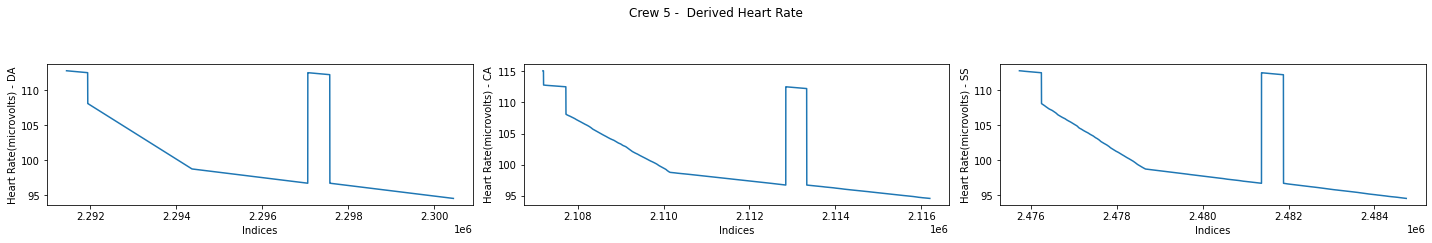

In [ ]:
fig = plt.figure(figsize=(20,8))
fig.suptitle('Crew 5 -  Derived Heart Rate')

plt.subplot(3,3, 1)
plt.plot(crew_5_df_da['heart_rate'])
plt.ylabel('Heart Rate(microvolts) - DA')
plt.xlabel('Indices')
plt.tight_layout() 

plt.subplot(3,3, 2)
plt.plot(crew_5_df_ca['heart_rate'])
plt.ylabel('Heart Rate(microvolts) - CA')
plt.xlabel('Indices')
plt.tight_layout() 

plt.subplot(3,3, 3)
plt.plot(crew_5_df_ss['heart_rate'])
plt.ylabel('Heart Rate(microvolts) - SS')
plt.xlabel('Indices')
plt.tight_layout() 

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()  

Deriving from EEG features

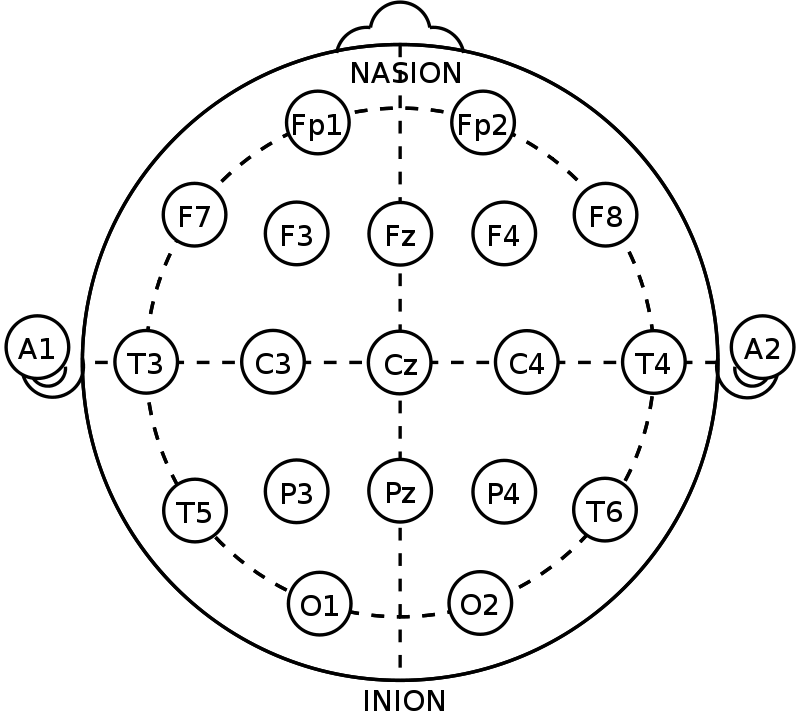

The EEG readings are from electrodes placed as shown in the figure above. We derive relevant features by combining the subsequent electrode values.

In [ ]:
#https://www.kaggle.com/stuartbman/introduction-to-physiological-data

aviation_df['fp1_f7'] = aviation_df['eeg_fp1'] - aviation_df['eeg_f7']
aviation_df['f7_t3'] = aviation_df['eeg_f7'] - aviation_df['eeg_t3']
aviation_df['t3_t5'] = aviation_df['eeg_t3'] - aviation_df['eeg_t5']
aviation_df['t5_o1'] = aviation_df['eeg_t5'] - aviation_df['eeg_o1']
aviation_df['fp1_f3'] = aviation_df['eeg_fp1'] - aviation_df['eeg_f7']
aviation_df['f3_c3'] = aviation_df['eeg_f3'] - aviation_df['eeg_c3']
aviation_df['c3_p3'] = aviation_df['eeg_c3'] - aviation_df['eeg_p3']
aviation_df['p3_o1'] = aviation_df['eeg_p3'] - aviation_df['eeg_o1']

aviation_df['fz_cz'] = aviation_df['eeg_fz'] - aviation_df['eeg_cz']
aviation_df['cz_pz'] = aviation_df['eeg_cz'] - aviation_df['eeg_pz']
aviation_df['pz_poz'] = aviation_df['eeg_pz'] - aviation_df['eeg_poz']

aviation_df['fp2_f8'] = aviation_df['eeg_fp2'] - aviation_df['eeg_f8']
aviation_df['f8_t4'] = aviation_df['eeg_f8'] - aviation_df['eeg_t4']
aviation_df['t4_t6'] = aviation_df['eeg_t4'] - aviation_df['eeg_t6']
aviation_df['t6_o2'] = aviation_df['eeg_t6'] - aviation_df['eeg_o2']
aviation_df['fp2_f4'] = aviation_df['eeg_fp2'] - aviation_df['eeg_f4']
aviation_df['f4_c4'] = aviation_df['eeg_f4'] - aviation_df['eeg_c4']
aviation_df['c4_p4'] = aviation_df['eeg_c4'] - aviation_df['eeg_p4']
aviation_df['p4_o2'] = aviation_df['eeg_p4'] - aviation_df['eeg_o2']

In [ ]:
aviation_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/train.csv.zip (Unzipped Files)/aviation_data2.csv')

In [ ]:
aviation_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event,denoised_r,denoised_ecg,r_rate,heart_rate,fp1_f7,f7_t3,t3_t5,t5_o1,fp1_f3,f3_c3,c3_p3,p3_o1,fz_cz,cz_pz,pz_poz,fp2_f8,f8_t4,t4_t6,t6_o2,fp2_f4,f4_c4,c4_p4,p4_o2
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,-6.695870,29.232100,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A,817.696269,-4520.903801,0.105434,115.631475,-32.061251,3.063502,-10.025200,4.505399,-32.061251,-2.149799,-4.246099,-4.389201,5.02662,-7.87249,-15.280560,2.831440,3.265890,-29.511000,2.210200,-9.786160,-34.278709,19.931400,2.929999
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,-6.474720,26.641399,24.138800,5.46991,20.510599,2.83354,7.10177,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A,817.451233,-4542.838352,0.105442,115.630362,-30.859321,7.420601,-9.433300,3.802201,-30.859321,-0.844101,-2.784100,-2.502599,1.50142,-4.13779,-14.219591,2.848790,-5.566280,-19.726530,-1.780900,-13.576490,-24.069029,11.771099,1.649500
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,-0.088707,28.119900,26.891300,8.57886,23.162901,4.51993,12.70550,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A,817.219470,-4563.578014,0.105450,115.629248,-19.748700,4.988399,-6.710998,4.022899,-19.748700,0.755301,-4.483700,-1.228600,2.98207,-7.04100,-14.592840,-15.439407,-9.373301,8.580900,-6.103899,-12.794207,24.718100,-31.408899,-2.850701
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,-0.256516,30.653601,24.247000,8.64310,19.961901,7.27575,11.45980,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A,817.013757,-4581.973235,0.105458,115.628135,-14.157300,6.467001,-12.351302,0.840500,-14.157300,0.625201,-4.910300,-6.406601,4.73083,-6.09818,-13.998099,-2.689596,-9.979420,-8.120800,1.534700,-11.716316,-7.114300,-4.582301,4.157801
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,-1.953470,31.722601,25.155500,12.50030,18.746901,7.30976,8.00805,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A,816.846138,-4596.940439,0.105466,115.627021,-18.659390,5.370500,-8.181499,-2.969002,-18.659390,-1.546299,-4.862300,-6.567101,5.61014,-10.80068,-10.170000,-2.067034,-5.634436,-14.085599,-2.979200,-9.961520,1.452610,-16.199260,-0.058099


#Deriving Frequency Bands from EEG


Theta band (4-7 Hz) - Drowsiness

Alpha band (7-13 Hz) - Relaxation


In [ ]:
#Use Biosppy to derive power features from the EEG readings. These power features are 
#required to further obtain the frequency band data of alpha and theta.

eeg_feature_names = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", 
                "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", 
                "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", 
                "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]
                
eeg_freq_arr = eeg.get_power_features(aviation_df[eeg_feature_names],sampling_rate=256)

print(eeg_freq_arr)

ReturnTuple(ts=array([0.0000000e+00, 1.2500000e-01, 2.5000000e-01, ..., 1.9012750e+04,
       1.9012875e+04, 1.9013000e+04]), theta=array([[0.00596342, 0.00315863, 0.00877005, ..., 0.01035285, 0.06036249,
        0.02282472],
       [0.00596342, 0.02123871, 0.00877005, ..., 0.01297208, 0.11920892,
        0.02282472],
       [0.00693823, 0.02123871, 0.0095076 , ..., 0.01504624, 0.19990487,
        0.02682934],
       ...,
       [0.20909035, 0.23265277, 0.05559772, ..., 0.23732202, 0.05480551,
        0.05271814],
       [0.20909035, 0.19739181, 0.04681299, ..., 0.23732202, 0.02832576,
        0.03500102],
       [0.08147898, 0.13945569, 0.04681299, ..., 0.23732202, 0.0045825 ,
        0.03471317]]), alpha_low=array([[0.00212337, 0.00710005, 0.00142458, ..., 0.00094662, 0.00191671,
        0.00088624],
       [0.00220207, 0.01019876, 0.00708469, ..., 0.00339632, 0.00320203,
        0.00300813],
       [0.00415528, 0.01019876, 0.0074162 , ..., 0.00339632, 0.00769663,
        0.00559322]

In [ ]:
#Derive features based on the alpha/theta frequency band. Perform interpolation to fetch data for all the time data.
def get_eeg_features(feature_key,arr_size,new_features_df):

  output = []

  for i in range(arr_size):
    feature_name = "egg_"+ feature_key + str(i)
    new_features_df[feature_name] = interpolation_fn(aviation_df["time"],eeg_freq_arr['ts'],eeg_freq_arr[feature_key][:,i])


In [ ]:
new_features_df = pd.DataFrame()

get_eeg_features('theta',20,new_features_df)
get_eeg_features('alpha_low',20,new_features_df)

print(new_features_df.columns)

Index(['egg_theta0', 'egg_theta1', 'egg_theta2', 'egg_theta3', 'egg_theta4',
       'egg_theta5', 'egg_theta6', 'egg_theta7', 'egg_theta8', 'egg_theta9',
       'egg_theta10', 'egg_theta11', 'egg_theta12', 'egg_theta13',
       'egg_theta14', 'egg_theta15', 'egg_theta16', 'egg_theta17',
       'egg_theta18', 'egg_theta19', 'egg_alpha_low0', 'egg_alpha_low1',
       'egg_alpha_low2', 'egg_alpha_low3', 'egg_alpha_low4', 'egg_alpha_low5',
       'egg_alpha_low6', 'egg_alpha_low7', 'egg_alpha_low8', 'egg_alpha_low9',
       'egg_alpha_low10', 'egg_alpha_low11', 'egg_alpha_low12',
       'egg_alpha_low13', 'egg_alpha_low14', 'egg_alpha_low15',
       'egg_alpha_low16', 'egg_alpha_low17', 'egg_alpha_low18',
       'egg_alpha_low19'],
      dtype='object')


In [ ]:
get_eeg_features('alpha_high',20,new_features_df)

In [ ]:
import gc

del eeg_freq_arr

gc.collect()

7352

Here, we derive the features for alpha and theta frequency bands from the EEG readings. These frequency bands give us more information like alpha indicates the relaxed state of the crew while theta indicates the drowsiness state of the crew.

#Deriving GSR Mean and (Maximum - Minimum) features for GSR

In [ ]:
gsr_mean = aviation_df['gsr'].rolling(window=4,min_periods=1).mean()
gsr_max = aviation_df['gsr'].rolling(window=4,min_periods=1).max()
gsr_min = aviation_df['gsr'].rolling(window=4,min_periods=1).min()

gsr_min_max = gsr_max - gsr_min


new_features_df['gsr_mean'] = gsr_mean
new_features_df['gsr_min_max'] = gsr_min_max

print(gsr_mean.shape)
print(gsr_min_max.shape)


In [ ]:
new_features_df.head()

,egg_theta0,egg_theta1,egg_theta2,egg_theta3,egg_theta4,egg_theta5,egg_theta6,egg_theta7,egg_theta8,egg_theta9,egg_theta10,egg_theta11,egg_theta12,egg_theta13,egg_theta14,egg_theta15,egg_theta16,egg_theta17,egg_theta18,egg_theta19,egg_alpha_low0,egg_alpha_low1,egg_alpha_low2,egg_alpha_low3,egg_alpha_low4,egg_alpha_low5,egg_alpha_low6,egg_alpha_low7,egg_alpha_low8,egg_alpha_low9,egg_alpha_low10,egg_alpha_low11,egg_alpha_low12,egg_alpha_low13,egg_alpha_low14,egg_alpha_low15,egg_alpha_low16,egg_alpha_low17,egg_alpha_low18,egg_alpha_low19,egg_alpha_high0,egg_alpha_high1,egg_alpha_high2,egg_alpha_high3,egg_alpha_high4,egg_alpha_high5,egg_alpha_high6,egg_alpha_high7,egg_alpha_high8,egg_alpha_high9,egg_alpha_high10,egg_alpha_high11,egg_alpha_high12,egg_alpha_high13,egg_alpha_high14,egg_alpha_high15,egg_alpha_high16,egg_alpha_high17,egg_alpha_high18,egg_alpha_high19,gsr_mean,gsr_min_max
0,0.005963,0.004854,0.00877,0.018957,0.017648,0.016128,0.028299,0.005302,0.011672,0.0316,0.006368,0.008407,0.026980,0.004075,0.002525,0.016995,0.011629,0.010598,0.065879,0.022825,0.002131,0.007391,0.001955,0.002819,0.001820,0.001515,0.001865,0.002613,0.002232,0.002588,0.000388,0.005327,0.002842,0.000768,0.001828,0.001913,0.001719,0.001176,0.002037,0.001085,0.001816,0.005783,0.004171,0.006323,0.001467,0.004083,0.001248,0.001977,0.004073,0.002563,0.000812,0.006548,0.001229,0.003105,0.004400,0.002121,0.001555,0.005902,0.002539,0.002471,388.829987,0.0
1,0.005963,0.005419,0.00877,0.019022,0.017648,0.016332,0.028299,0.005302,0.011672,0.0316,0.006390,0.008715,0.027827,0.004105,0.002873,0.016995,0.011629,0.010680,0.067718,0.022825,0.002133,0.007487,0.002132,0.002899,0.001923,0.001614,0.001865,0.002621,0.002234,0.002588,0.000414,0.005395,0.003181,0.000891,0.001991,0.001913,0.001719,0.001253,0.002077,0.001151,0.002077,0.005833,0.004283,0.006591,0.001539,0.004087,0.001301,0.001997,0.004073,0.002563,0.000822,0.006550,0.001437,0.003462,0.004586,0.002136,0.001555,0.005902,0.002572,0.002471,388.829987,0.0
2,0.005963,0.005984,0.00877,0.019087,0.017648,0.016537,0.028299,0.005302,0.011672,0.0316,0.006412,0.009023,0.028673,0.004134,0.003220,0.016995,0.011629,0.010762,0.069557,0.022825,0.002136,0.007584,0.002309,0.002979,0.002025,0.001712,0.001865,0.002630,0.002236,0.002588,0.000439,0.005462,0.003520,0.001015,0.002155,0.001913,0.001719,0.001329,0.002118,0.001218,0.002338,0.005883,0.004394,0.006858,0.001611,0.004091,0.001354,0.002017,0.004073,0.002563,0.000833,0.006552,0.001646,0.003818,0.004771,0.002151,0.001555,0.005902,0.002605,0.002471,388.829987,0.0
3,0.005963,0.006549,0.00877,0.019152,0.017648,0.016741,0.028299,0.005302,0.011672,0.0316,0.006434,0.009331,0.029519,0.004164,0.003568,0.016995,0.011629,0.010844,0.071396,0.022825,0.002138,0.007681,0.002486,0.003058,0.002128,0.001811,0.001865,0.002638,0.002238,0.002588,0.000465,0.005530,0.003860,0.001138,0.002319,0.001913,0.001719,0.001406,0.002158,0.001284,0.002599,0.005933,0.004506,0.007125,0.001683,0.004094,0.001407,0.002037,0.004073,0.002563,0.000843,0.006554,0.001854,0.004174,0.004957,0.002166,0.001555,0.005902,0.002638,0.002471,388.829987,0.0
4,0.005963,0.007114,0.00877,0.019217,0.017648,0.016945,0.028299,0.005302,0.011672,0.0316,0.006456,0.009639,0.030365,0.004194,0.003915,0.016995,0.011629,0.010926,0.073235,0.022825,0.002141,0.007778,0.002663,0.003138,0.002230,0.001910,0.001865,0.002647,0.002241,0.002588,0.000490,0.005597,0.004199,0.001261,0.002482,0.001913,0.001719,0.001482,0.002198,0.001350,0.002860,0.005983,0.004618,0.007392,0.001754,0.004098,0.001459,0.002057,0.004073,0.002563,0.000853,0.006556,0.002062,0.004531,0.005143,0.002181,0.001555,0.005902,0.002671,0.002471,388.829987,0.0


In [ ]:
new_features_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/train.csv.zip (Unzipped Files)/new_features_df1.csv')

In [ ]:
plt.figure(figsize=(10, 10))

sns.boxplot(x=aviation_df['event'],y=new_features_df['gsr_mean'])

We notice certain outliers in the gsr_mean for the classes - A and D. These outliers may be useful in predicting the D class.

In [ ]:
new_features_df = dd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/train.csv.zip (Unzipped Files)/new_features_df1.csv')
aviation_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/train.csv.zip (Unzipped Files)/aviation_data2.csv')

##Encode the Categorical variables

In [ ]:

labelencoder = LabelEncoder()

eventClass = labelencoder.fit_transform(aviation_df['event'])

aviation_df['target'] = eventClass

In [ ]:
aviation_df.drop(['experiment','event','ecg','r'],inplace=True,axis = 1)
aviation_df.drop(["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", 
                "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", 
                "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", 
                "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"],inplace=True,axis=1)

Drop the experiment and event features as they have been encoded.

Drop the ecg and r features as we have already extracted the denoised ecg and r. 

In [ ]:
final_train_data = dd.merge(aviation_df, new_features_df)

In [ ]:
final_train_data = final_train_data.compute() 

In [ ]:
final_train_data.columns

Index(['Unnamed: 0', 'crew', 'time', 'seat', 'gsr', 'denoised_r',
       'denoised_ecg', 'r_rate', 'heart_rate', 'fp1_f7', 'f7_t3', 't3_t5',
       't5_o1', 'fp1_f3', 'f3_c3', 'c3_p3', 'p3_o1', 'fz_cz', 'cz_pz',
       'pz_poz', 'fp2_f8', 'f8_t4', 't4_t6', 't6_o2', 'fp2_f4', 'f4_c4',
       'c4_p4', 'p4_o2', 'target', 'egg_theta0', 'egg_theta1', 'egg_theta2',
       'egg_theta3', 'egg_theta4', 'egg_theta5', 'egg_theta6', 'egg_theta7',
       'egg_theta8', 'egg_theta9', 'egg_theta10', 'egg_theta11', 'egg_theta12',
       'egg_theta13', 'egg_theta14', 'egg_theta15', 'egg_theta16',
       'egg_theta17', 'egg_theta18', 'egg_theta19', 'egg_alpha_low0',
       'egg_alpha_low1', 'egg_alpha_low2', 'egg_alpha_low3', 'egg_alpha_low4',
       'egg_alpha_low5', 'egg_alpha_low6', 'egg_alpha_low7', 'egg_alpha_low8',
       'egg_alpha_low9', 'egg_alpha_low10', 'egg_alpha_low11',
       'egg_alpha_low12', 'egg_alpha_low13', 'egg_alpha_low14',
       'egg_alpha_low15', 'egg_alpha_low16', 'egg_alpha_low

In [ ]:
final_train_data.head()

,Unnamed: 0,crew,time,seat,gsr,denoised_r,denoised_ecg,r_rate,heart_rate,fp1_f7,f7_t3,t3_t5,t5_o1,fp1_f3,f3_c3,c3_p3,p3_o1,fz_cz,cz_pz,pz_poz,fp2_f8,f8_t4,t4_t6,t6_o2,fp2_f4,f4_c4,c4_p4,p4_o2,target,egg_theta0,egg_theta1,egg_theta2,egg_theta3,egg_theta4,egg_theta5,egg_theta6,egg_theta7,egg_theta8,egg_theta9,egg_theta10,...,egg_alpha_low2,egg_alpha_low3,egg_alpha_low4,egg_alpha_low5,egg_alpha_low6,egg_alpha_low7,egg_alpha_low8,egg_alpha_low9,egg_alpha_low10,egg_alpha_low11,egg_alpha_low12,egg_alpha_low13,egg_alpha_low14,egg_alpha_low15,egg_alpha_low16,egg_alpha_low17,egg_alpha_low18,egg_alpha_low19,egg_alpha_high0,egg_alpha_high1,egg_alpha_high2,egg_alpha_high3,egg_alpha_high4,egg_alpha_high5,egg_alpha_high6,egg_alpha_high7,egg_alpha_high8,egg_alpha_high9,egg_alpha_high10,egg_alpha_high11,egg_alpha_high12,egg_alpha_high13,egg_alpha_high14,egg_alpha_high15,egg_alpha_high16,egg_alpha_high17,egg_alpha_high18,egg_alpha_high19,gsr_mean,gsr_min_max
0,0,1,0.011719,1,388.829987,817.696269,-4520.903801,0.105434,115.631475,-32.061251,3.063502,-10.025200,4.505399,-32.061251,-2.149799,-4.246099,-4.389201,5.02662,-7.87249,-15.280560,2.831440,3.265890,-29.511000,2.210200,-9.786160,-34.278709,19.931400,2.929999,0,0.005963,0.004854,0.00877,0.018957,0.017648,0.016128,0.028299,0.005302,0.011672,0.0316,0.006368,...,0.001955,0.002819,0.001820,0.001515,0.001865,0.002613,0.002232,0.002588,0.000388,0.005327,0.002842,0.000768,0.001828,0.001913,0.001719,0.001176,0.002037,0.001085,0.001816,0.005783,0.004171,0.006323,0.001467,0.004083,0.001248,0.001977,0.004073,0.002563,0.000812,0.006548,0.001229,0.003105,0.004400,0.002121,0.001555,0.005902,0.002539,0.002471,388.829987,0.0
1,1,1,0.015625,1,388.829987,817.451233,-4542.838352,0.105442,115.630362,-30.859321,7.420601,-9.433300,3.802201,-30.859321,-0.844101,-2.784100,-2.502599,1.50142,-4.13779,-14.219591,2.848790,-5.566280,-19.726530,-1.780900,-13.576490,-24.069029,11.771099,1.649500,0,0.005963,0.005419,0.00877,0.019022,0.017648,0.016332,0.028299,0.005302,0.011672,0.0316,0.006390,...,0.002132,0.002899,0.001923,0.001614,0.001865,0.002621,0.002234,0.002588,0.000414,0.005395,0.003181,0.000891,0.001991,0.001913,0.001719,0.001253,0.002077,0.001151,0.002077,0.005833,0.004283,0.006591,0.001539,0.004087,0.001301,0.001997,0.004073,0.002563,0.000822,0.006550,0.001437,0.003462,0.004586,0.002136,0.001555,0.005902,0.002572,0.002471,388.829987,0.0
2,2,1,0.019531,1,388.829987,817.219470,-4563.578014,0.105450,115.629248,-19.748700,4.988399,-6.710998,4.022899,-19.748700,0.755301,-4.483700,-1.228600,2.98207,-7.04100,-14.592840,-15.439407,-9.373301,8.580900,-6.103899,-12.794207,24.718100,-31.408899,-2.850701,0,0.005963,0.005984,0.00877,0.019087,0.017648,0.016537,0.028299,0.005302,0.011672,0.0316,0.006412,...,0.002309,0.002979,0.002025,0.001712,0.001865,0.002630,0.002236,0.002588,0.000439,0.005462,0.003520,0.001015,0.002155,0.001913,0.001719,0.001329,0.002118,0.001218,0.002338,0.005883,0.004394,0.006858,0.001611,0.004091,0.001354,0.002017,0.004073,0.002563,0.000833,0.006552,0.001646,0.003818,0.004771,0.002151,0.001555,0.005902,0.002605,0.002471,388.829987,0.0
3,3,1,0.023438,1,388.829987,817.013757,-4581.973235,0.105458,115.628135,-14.157300,6.467001,-12.351302,0.840500,-14.157300,0.625201,-4.910300,-6.406601,4.73083,-6.09818,-13.998099,-2.689596,-9.979420,-8.120800,1.534700,-11.716316,-7.114300,-4.582301,4.157801,0,0.005963,0.006549,0.00877,0.019152,0.017648,0.016741,0.028299,0.005302,0.011672,0.0316,0.006434,...,0.002486,0.003058,0.002128,0.001811,0.001865,0.002638,0.002238,0.002588,0.000465,0.005530,0.003860,0.001138,0.002319,0.001913,0.001719,0.001406,0.002158,0.001284,0.002599,0.005933,0.004506,0.007125,0.001683,0.004094,0.001407,0.002037,0.004073,0.002563,0.000843,0.006554,0.001854,0.004174,0.004957,0.002166,0.001555,0.005902,0.002638,0.002471,388.829987,0.0
4,4,1,0.027344,1,388.829987,816.846138,-4596.940439,0.105466,115.627021,-18.659390,5.370500,-8.181499,-2.969002,-18.659390,-1.546299,-4.862300,-6.567101,5.61014,-10.800

In [ ]:
final_train_data =reduce_mem_usage(final_train_data)

Memory usage of dataframe is 3416.46 MB
Memory usage after optimization is: 877.33 MB
Decreased by 74.3%


In [ ]:
final_train_data.to_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/pre-processed_train1')

##Summary

1. This is an imbalanced dataset with a huge representation of class C and a significant lesser representation for D and B classes.
2. The experiments are fairly balanced amongst the crews except for experiment B for crew1.Crew 1 had a lesser experiments of the B class.
3. A lot of noise was found in the physiological data. All these data were de-noised.
4. New features were generated based on the ECG, Respiration rate, GSR , EEG data.
5. The EEG features were found to be highly correlated amongst themselves.
6. Dask was used to efficiently handle the huge dataframe and prevent system crashes. 